# DVL-NAV -- Unit 770
04/06/2022
Gregory Burgess

---

1. [Import Libraries](#import-libraries)
1. [Load and Parse Data](#load-and-parse-data)
    1. [Bathymetry Data](#import-bathymetry)
    1. [Glider Flight Computer Data](#import-glider-flight-computer)
    1. [Rosbag Data](#import-rosbag-data)
    1. [Separate and Select Dives](#separate-and-select-dives)
    1. [DVL Data](#import-dvl-data)
1. [Compute Water Column Currents](#compute-water-column-currents)
1. [Compute DVL-Odometry](#compute-dvl-odometry)
1. [Multi-Factor Terrain Based Navigation](#multi-factor-terrain-based-navigation)
    <!-- 1. [Plot Navigation Results](#plot-navigation-results)
    1. [Navigation Performance](#navigation-performance)
        2. [Print Performance metrics](#print_metrics) -->
1. [More Plotting Tools](#more-plotting-tools)
1. [Sandbox](#sandbox)


---
<a id='import-libraries'></a>
## Import Libraries

In [71]:
import datetime
import earthpy as et
import earthpy.plot as ep
import importlib
import numpy as np
import os
import pandas as pd
import rasterio as rio
import scipy
import scipy.signal
import seaborn as sns 
import struct
import sys
import utm
import unittest
from PIL import Image
from matplotlib import pyplot as plt 
from os import listdir
from os.path import isfile, join
from scipy.spatial.transform import Rotation as R
from scipy import interpolate

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))

sys.path.append(os.path.join(sys.path[0], '../data'))

# objects for parsing raw DVL data 
import PathfinderDVL
import PathfinderEnsemble
import PathfinderTimeSeries

# objects for estimating ocean current velocities
import VelocityShearPropagation

# objects for controlling thruster to minimize transport cost 
import AdaptiveVelocityController

# objects for parsing flight and science computer log files
import SlocumFlightController
import SlocumScienceController
import dvl_plotter
import BathymetryMap
import MultiFactorTAN
import dvl_plotter_unit770_PR

# data for parsing seafloor bathymetry
# import bathy_meta_data
sns.set()

# %matplotlib notebook


import warnings
warnings.simplefilter('ignore')

def reload_modules():
    importlib.reload(PathfinderDVL)
    importlib.reload(PathfinderEnsemble)
    importlib.reload(PathfinderTimeSeries)
    importlib.reload(VelocityShearPropagation)
    importlib.reload(AdaptiveVelocityController)
    importlib.reload(SlocumFlightController)
    importlib.reload(SlocumScienceController)
    importlib.reload(dvl_plotter)
    importlib.reload(dvl_plotter_unit770_PR)
#     importlib.reload(bathy_meta_data)
    importlib.reload(BathymetryMap)
    importlib.reload(MultiFactorTAN)
print('Done!')

Done!


In [72]:
filepath = '/home/kraft/workspace/data/glider/BuzzBay/28JUN/'
# filepath = '/home/glider-sim/dvl-nav/data/field_data/buzz_bay/jun28/'
# filepath = '/home/glider-sim/dvl-nav/data/field_data/puerto_rico/mar9/'

---
<a id='load-and-parse-data'></a>
## Load and Parse Data
<a id='import-bathymetry'></a>
### Bathymetry Data

In [73]:
reload_modules()
# 1/9 arc second CUDEM used (approx 3.4m resolution)
# Grid_res_num should always represent original resolution of the bathymetry chart. Then, the Minimum spatial resolution will be half that.
# Location Options TS1 (Test Site 1), OFF_SHELF, SHELF
# Resolution Options: 1, 2, 3, 6, 9, 12 (3.4m, 6.8m, 10.2m, 20.4m, 30.6m, 40.8m)
# 3.4m resolution
bathy_df = pd.read_csv('/home/kraft/workspace/data/glider/PuertoRico/bathy/puertoRico_TS1-3.csv')
# bathy_df = pd.read_csv('/home/gburgess/dvl-nav/data/field_data/kolumbo/bathy/Kolumbo-1.csv')
# bathy_df = pd.read_csv('/home/glider-sim/dvl-nav/data/field_data/puerto_rico/bathy/puertoRico_TS1-3.csv')
# bathy_df = pd.read_csv('/home/glider-sim/dvl-nav/data/field_data/puerto_rico/bathy/puertoRico_SHELF-3.csv')
# bathy_df = pd.read_csv('/home/glider-sim/dvl-nav/data/field_data/puerto_rico/bathy/puertoRico_OFF_SHELF-3.csv')
# bathy_df = pd.read_csv('/home/glider-sim/dvl-nav/data/field_data/puerto_rico/bathy/puertoRico_bathy.csv')
# bathy_df = pd.read_csv('/home/glider-sim/dvl-nav/data/field_data/buzz_bay/bathy/buzzBay-1.csv')
grid_res_num = 10.2


# 3.4m resolution
# bathy_df_var = pd.read_csv('/home/gburgess/dvl-nav/data/field_data/kolumbo/bathy/Kolumbo-2.csv')
bathy_df_var = pd.read_csv('/home/kraft/workspace/data/glider/PuertoRico/bathy/puertoRico_TS1-6.csv')
# bathy_df_var = pd.read_csv('/home/glider-sim/dvl-nav/data/field_data/puerto_rico/bathy/puertoRico_SHELF-6.csv')
# bathy_df_var = pd.read_csv('/home/glider-sim/dvl-nav/data/field_data/puerto_rico/bathy/puertoRico_OFF_SHELF-6.csv')
# bathy_df_var = pd.read_csv('/home/glider-sim/dvl-nav/data/field_data/puerto_rico/bathy/puertoRico_bathy_var.csv')
# bathy_df = pd.read_csv('/home/glider-sim/dvl-nav/data/field_data/buzz_bay/bathy/buzzBay-2.csv')
map_var_resolution = '20m'

<a id='import-glider-flight-computer'></a>
### Glider Flight Computer Data

In [74]:
reload_modules()
directory = filepath+'dbd_parsed/'
ts_flight = SlocumFlightController.SlocumFlightController.from_directory(directory, save=False, verbose=False)
# ts_flight.df.to_csv('DBD_JUL28.csv', sep=',' , index=False)
# ts_flight.df.to_csv(filepath+'ts_flight.csv', sep=',' , index=False)
#ts_flight.df.head()


>> Parsing folder of ASC Files
>> Finished Parsing!


<IPython.core.display.Javascript object>


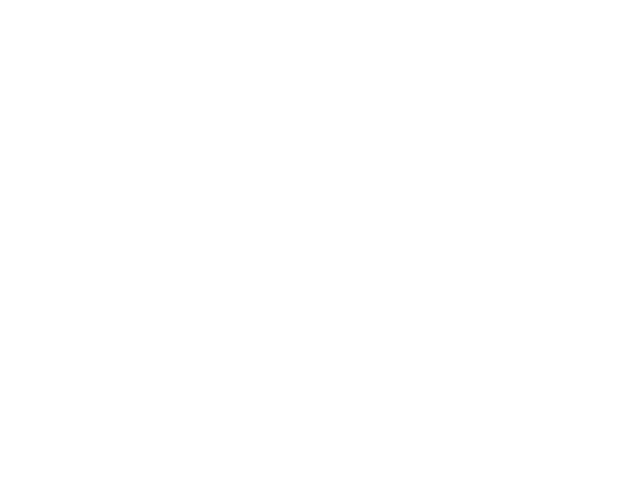

In [75]:
plt.figure()
plt.plot(ts_flight.df.m_depth, 'o')

In [76]:
def get_utm_coords_from_glider_lat_lon(m_lat, m_lon):
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = np.abs(m_lon) % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon + lon_min)/MIN_OFFSET - lon_min/SECS_IN_MIN
    try:
        utm_pos  = utm.from_latlon(lat_dec, lon_dec)
        easting  = round(utm_pos[0],2)
        northing = round(utm_pos[1],2)
        zone     = utm_pos[2]
        zone_letter  = utm_pos[3]
    except:
        easting = np.nan
        northing = np.nan
        zone = None
        zone_letter = None
    return(easting, northing, zone, zone_letter)

# utm_x_list = []
# utm_y_list = []
# utm_x_gps_list = []
# utm_y_gps_list = []
# for i in range(0,len(df_dbd.m_lat)):
#     utm_x, utm_y,_,_ = get_utm_coords_from_glider_lat_lon(df_dbd.m_lat[i], df_dbd.m_lon[i])
#     utm_x_gps, utm_y_gps,_,_ = get_utm_coords_from_glider_lat_lon(df_dbd.m_gps_lat[i], df_dbd.m_gps_lon[i])
#     utm_x_list.append(utm_x)
#     utm_y_list.append(utm_y)
#     utm_x_gps_list.append(utm_x_gps)
#     utm_y_gps_list.append(utm_y_gps)

# utm_x_gps_list_filt = []
# utm_y_gps_list_filt = []
# for i in range(0,len(utm_x_gps_list)):
#     if not np.isnan(utm_x_gps_list[i]):
#         utm_x_gps_list_filt.append(utm_x_gps_list[i] - utm_x_gps_list[1])
#         utm_y_gps_list_filt.append(utm_y_gps_list[i] - utm_y_gps_list[1])
#     else:
#         utm_x_gps_list_filt.append(None)
#         utm_y_gps_list_filt.append(None)

# fig,ax = plt.subplots(figsize=(25,15))
# sns.scatterplot(df_dbd.m_lon, df_dbd.m_lat, color='purple', label='DR-DACC')
# sns.scatterplot(df_dbd.m_gps_lon,df_dbd.m_gps_lat, color='tab:red', marker='+', s=300, label='GPS')
# # sns.scatterplot(ts_flight.df.m_x_lmc, ts_flight.df.m_y_lmc, color='purple', label='DR-DACC')
# # sns.scatterplot(ts_flight.df.m_gps_x_lmc, ts_flight.df.m_gps_y_lmc,color='tab:red', marker='+', s=300, label='GPS')

# fig,ax = plt.subplots(figsize=(25,15))
# sns.scatterplot(utm_x_list-utm_x_list[0], utm_y_list-utm_y_list[0], color='purple', label='DR-DACC')
# sns.scatterplot(utm_x_gps_list_filt, utm_y_gps_list_filt, color='tab:red', marker='+', s=300, label='GPS')
# utm_x_gps_list[1]

<a id='import-rosbag-data'></a>
### Rosbag Data

In [77]:
# EXTCTL - GLider 
# m_lon_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_lon.csv')
# m_lat_df        = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_lat.csv')
# m_gps_lon_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_gps_lon.csv')
# m_gps_lat_df    = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_gps_lat.csv')
# m_depth_df      = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_depth.csv')
# m_pitch_df      = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_pitch.csv')
# m_roll_df       = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_roll.csv')
# m_altitude_df   = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_altitude.csv')
# m_alt_status_df = pd.read_csv(filepath+ 'rosbags/rosbag_output/' + 'extctl-sensors-m_altimeter_status.csv')

# Micron Sonar

#TODO 

#split out m_gps_lat and m_lat (i think is deadreckoned ) for each dive
# Why are the m_lat and m_lon as well as m_gps_lat and m_gps_lon not 1:1 different lengths???


<a id='separate-and-select-dives'></a>
### Separate and Select Dives

Zeroing out CTD Data. Est Surface Depth: 2.9200000762939453


<IPython.core.display.Javascript object>


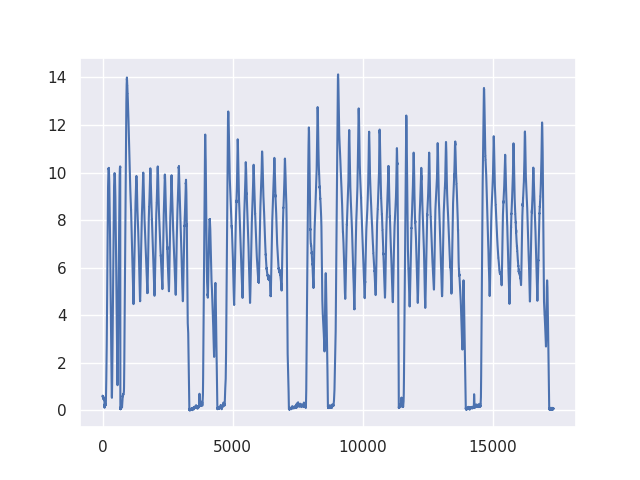

In [78]:
ctd_df = pd.read_csv(filepath+ 'rosbag_output/' + 'ctd-data.csv')
# "Zero" out CTD by determining the measured depth at which the glider spent the most time and under 6m
n, bins, patches = plt.hist(x=ctd_df.depth, bins= 'auto' )
bins
nbins = 0
for b in bins:
    if b > 6.0:
        break
    nbins += 1
#print(nbins)
target = n[0]
target_idx = 0
i = 0
for b in range(1,nbins):
    i = i+1
    if n[b] > target:
        target = n[b]
        target_idx = i
#print(target, target_idx, bins[target_idx])
est_surface_depth = bins[target_idx]
print('Zeroing out CTD Data. Est Surface Depth: ' + str(est_surface_depth))
ctd_df.depth = ctd_df.depth - est_surface_depth
plt.figure()
plt.plot(ctd_df.depth)


<IPython.core.display.Javascript object>


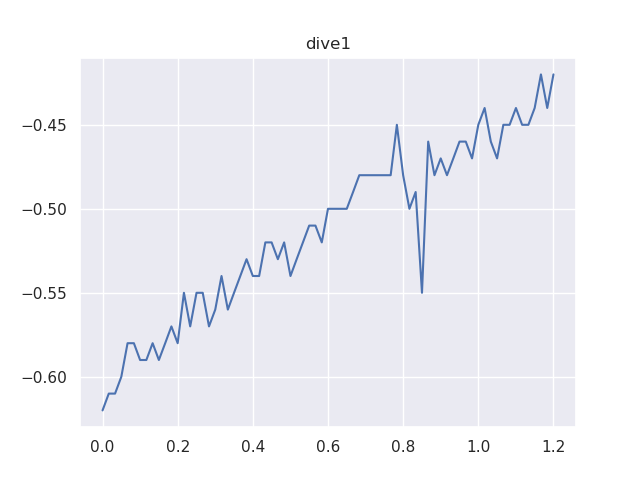

<IPython.core.display.Javascript object>


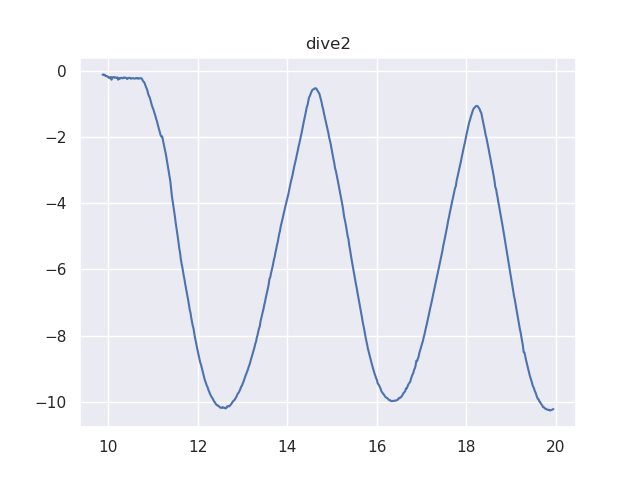

<IPython.core.display.Javascript object>


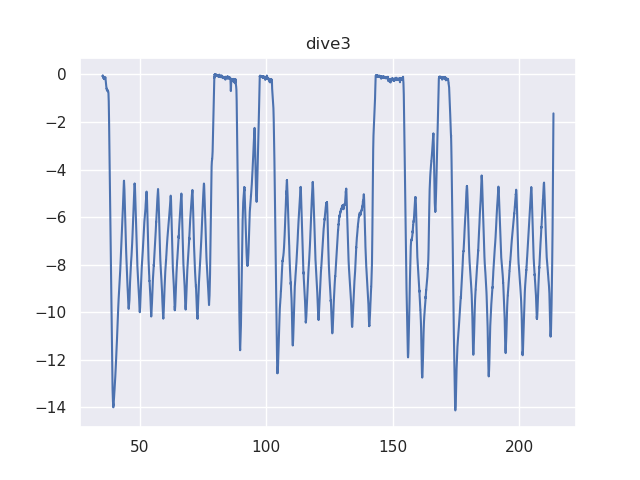

<IPython.core.display.Javascript object>


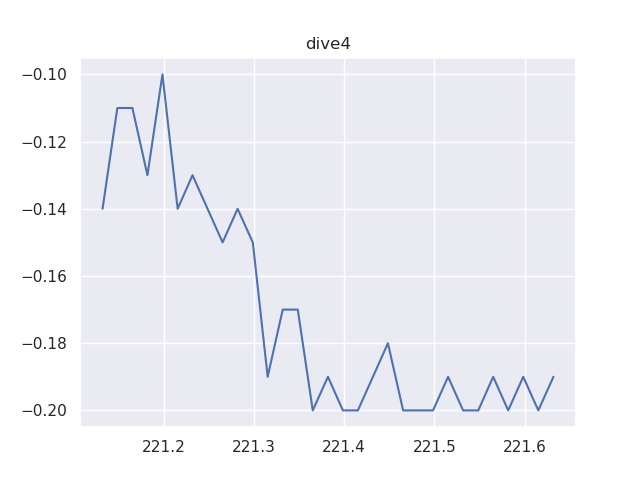

<IPython.core.display.Javascript object>


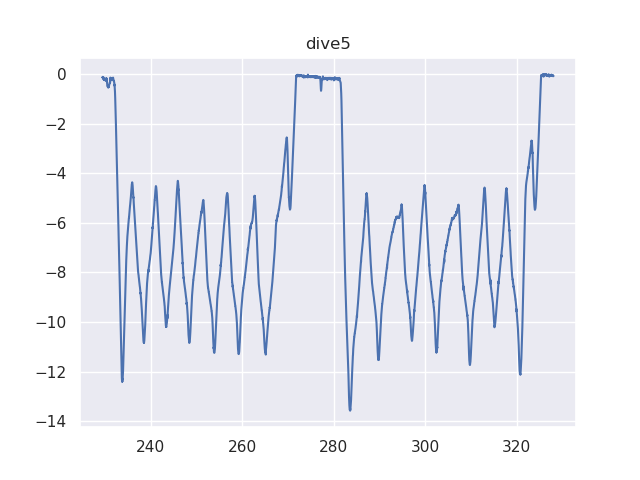

In [79]:
# Use CTD to determine start and end points of dives
dive_dic = {}
dive_dic['dive1'] = [0]
count = 0
for i in range(1,len(ctd_df.Time)):
    dt = ctd_df.Time[i] - ctd_df.Time[i-1]
    if dt > 5.0:
        count += 1
        dive_dic['dive'+str(count)].append(i-1)
        dive_dic['dive'+str(count+1)] = [i]
dive_dic['dive'+str(count+1)].append(len(ctd_df.Time)-1)

# Create DateTime Column to make it easier to read
#ctd_df['Time'] = pd.to_datetime(ctd_df['header.stamp.secs'], unit='s')
ctd_df['Time_easy'] = (ctd_df['Time'] - ctd_df.Time[0])/60
for key in dive_dic:
    plt.figure()
    plt.plot(ctd_df.Time_easy[dive_dic[key][0]:dive_dic[key][1]], ctd_df.depth[dive_dic[key][0]:dive_dic[key][1]]*-1)
    plt.title(key)


### Select Dive

In [80]:
selected_dive = 'dive3'

---
### Based upon selected dive, split out flight computer data and DVL data
Flight Computer

2022-06-28 13:34:59.240252 2022-06-28 16:33:21.964371
Duration: 2:58:22.724118
2022-06-28 18:34:25.940253 2022-06-28 21:32:48.664371


<IPython.core.display.Javascript object>


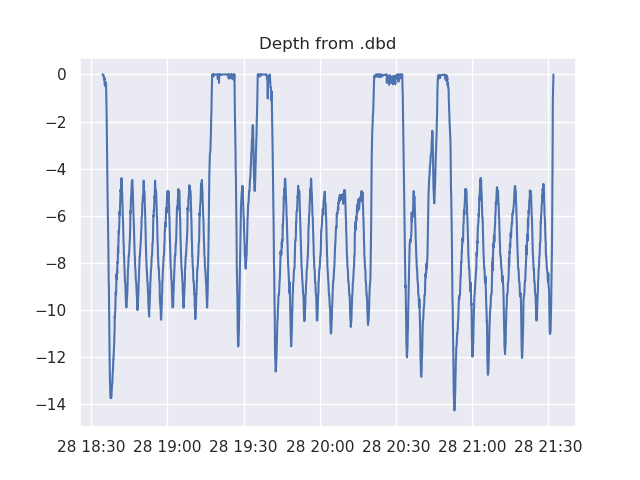

Text(0.5, 1.0, 'Depth from .dbd')

In [81]:
ctd_start = ctd_df.Time[dive_dic[selected_dive][0]]
ctd_end = ctd_df.Time[dive_dic[selected_dive][1]]
print(datetime.datetime.fromtimestamp(ctd_start), datetime.datetime.fromtimestamp(ctd_end))

# Trim Dive due to ABORT to make for cleaner data processing (only March 17 dive 6)
# ctd_start = ctd_df.Time[dive_dic[selected_dive][0]]
# ctd_end = ctd_df.Time[7200]

# time_zone_shift = 3600*5
time_zone_shift = 3600*(5-0.00925)

start_t = datetime.datetime.fromtimestamp(ctd_start+time_zone_shift)
end_t   = datetime.datetime.fromtimestamp(ctd_end+time_zone_shift)
dur     = end_t - start_t 
print("Duration:", dur)
print(start_t, end_t)

df_dbd  = ts_flight.df[str(start_t):str(end_t)].copy()

#JUST FOR MAR17 dive 6
# df_dbd  = pd.read_csv(filepath + 'df_dbd.csv')
# df_dbd.to_csv(filepath+'mar17_bad_dive_flight_data.csv', sep=',', index=False)

plt.figure()
plt.plot(df_dbd.m_depth*-1)
plt.title('Depth from .dbd')



Interpolate AHRS and CTD Data to enable matching data to DVL timestamp

In [82]:
# Interpolate AHRS and CTD data onto DVL timestamp. Simplest solution for post-processing.
# TODO consider how to trasnfer this to live application

time_dbd = df_dbd.time- time_zone_shift
RAD_TO_DEG = 180/scipy.pi
try:
    ahrs_df = pd.read_csv(filepath + 'rosbags/rosbag_output/' + 'devices-spartonm2-ahrs.csv')
    # ahrs_df.head()
    f_roll = scipy.interpolate.interp1d(ahrs_df.Time, ahrs_df.roll, 'nearest')
    f_pitch = scipy.interpolate.interp1d(ahrs_df.Time, ahrs_df.pitch, 'nearest')
    f_heading = scipy.interpolate.interp1d(ahrs_df.Time, ahrs_df['compass.heading'], 'nearest')
    print('Sparton AHRS Data Available and collected at 10 Hz')

except:
    # Mar 11 and Mar 14 - use TCM3
    f_roll = scipy.interpolate.interp1d(time_dbd, df_dbd.m_roll * RAD_TO_DEG, 'linear')
    f_pitch = scipy.interpolate.interp1d(time_dbd, df_dbd.m_pitch * RAD_TO_DEG, 'linear')
    f_heading = scipy.interpolate.interp1d(time_dbd, df_dbd.m_heading * RAD_TO_DEG, 'linear')
    print('TCM-3 IMU available and collected at 0.25 Hz')

# CTD
# f_depth = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.depth, 'linear')
# f_temp = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.temperature, 'linear')
# f_cond = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.conductivity, 'linear')
f_depth = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.depth, 'nearest')
f_temp = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.temperature, 'nearest')
f_cond = scipy.interpolate.interp1d(ctd_df.Time, ctd_df.conductivity, 'nearest')

TCM-3 IMU available and collected at 0.25 Hz


DVL Data

In [83]:
# Upload DVL rosbags
dvl_df        = pd.read_csv(filepath+ 'rosbag_output/' + 'devices-dvl-dvl.csv')
dvl_pd0_df    = pd.read_csv(filepath+ 'rosbag_output/' + 'devices-dvl-pd0.csv')
dvl_ranges_df = pd.read_csv(filepath+ 'rosbag_output/' + 'devices-dvl-ranges.csv')
dvl_raw_df    = pd.read_csv(filepath+ 'rosbag_output/' + 'devices-dvl-instrument-raw.csv')

dvl_raw_df_new = dvl_raw_df.set_index('Time')

start_dvl = dvl_raw_df_new.index.get_loc(ctd_start, method='nearest')
end_dvl = dvl_raw_df_new.index.get_loc(ctd_end, method='nearest')
print(start_dvl, end_dvl)

2607 13309


In [84]:
print(datetime.datetime.fromtimestamp(dvl_df.Time[0]))
print(datetime.datetime.fromtimestamp(dvl_df.Time[len(dvl_df.Time)-1]))

2022-06-28 12:51:32.934803
2022-06-28 18:28:24.846167


In [85]:
# Specific to when using DBD data as IMU
print('DBD Start: ', time_dbd[0], ' DBD END: ', time_dbd[-1])
print('DVL Start: ', dvl_raw_df.Time[start_dvl], ' DVL END: ', dvl_raw_df.Time[end_dvl])
print('Diff start: ',time_dbd[0] -dvl_raw_df.Time[start_dvl]  , ' Diff end: ', time_dbd[-1] -dvl_raw_df.Time[end_dvl])

DBD Start:  1656437700.83549  DBD END:  1656448351.6089
DVL Start:  1656437699.1844225  DVL END:  1656448402.078451
Diff start:  1.6510674953460693  Diff end:  -50.4695508480072


In [86]:
# Specific to when using DBD data as IMU
print('CTD Start: ', ctd_start, ' CTD end: ', ctd_end)
print('DBD Start: ', time_dbd[0], ' DBD END: ', time_dbd[-1])
print('Diff start: ',time_dbd[0] - ctd_start  , ' Diff end: ', time_dbd[-1] - ctd_end)

start_adjustment = int(np.ceil(time_dbd[0] - ctd_start))
end_adjustment = int(np.ceil(np.abs(time_dbd[-1] - ctd_end)))


CTD Start:  1656437699.2402525  CTD end:  1656448401.9643712
DBD Start:  1656437700.83549  DBD END:  1656448351.6089
Diff start:  1.5952374935150146  Diff end:  -50.35547113418579


In [87]:
# reload_modules()
# # Initialize Timseries object
# ts = PathfinderTimeSeries.PathfinderTimeSeries()
# prev_ensemble = None
# error_count = 0
# for i in range(0,len(dvl_raw_df.Time)):
#     try:
#         ros_timestamp = dvl_raw_df.Time[i]
#         roll = f_roll(ros_timestamp)
#         pitch = f_pitch(ros_timestamp)
#         heading = f_pitch(ros_timestamp)

#         ensemble_raw = dvl_raw_df.data[i][2:-1]
#         ensemble_bytes = ensemble_raw.encode().decode('unicode_escape').encode("raw_unicode_escape")
#         ensemble = PathfinderEnsemble.PathfinderEnsemble(ensemble_bytes, prev_ensemble, gps_fix=None, ros_time=ros_timestamp, \
#                                                          ext_roll=roll, ext_pitch=pitch, ext_heading=heading)
#         ts.add_ensemble(ensemble)
#         prev_ensemble = ensemble
#     except:
#         error_count += 1
#         continue
# ts.to_dataframe()
# print('Error Count: ' + str(error_count))
# ts.df.to_csv('DVL_MAR9.csv', sep=',' , index=False)
#TODO add dvl odo in ??

In [88]:
reload_modules()
# Initialize Timseries object
ts = PathfinderTimeSeries.PathfinderTimeSeries()
prev_ensemble = None
error_count = 0
for i in range(start_dvl + start_adjustment, end_dvl-end_adjustment):
    ros_timestamp = dvl_raw_df.Time[i]
    roll = f_roll(ros_timestamp)
    pitch = f_pitch(ros_timestamp)
    heading = f_heading(ros_timestamp)
    depth = f_depth(ros_timestamp)
    temp = f_temp(ros_timestamp)
    cond = f_cond(ros_timestamp)
    ensemble_raw = dvl_raw_df.data[i][2:-1]
    ensemble_bytes = ensemble_raw.encode().decode('unicode_escape').encode("raw_unicode_escape")
    ensemble = PathfinderEnsemble.PathfinderEnsemble(ensemble_bytes, prev_ensemble, gps_fix=None, ros_time=ros_timestamp, \
                                                    ext_roll=roll, ext_pitch=pitch, ext_heading=heading, \
                                                    ext_depth=depth, ext_temp=temp, ext_cond=cond)
    ts.add_ensemble(ensemble)
    prev_ensemble = ensemble

                
ts.to_dataframe()
# ts.df.to_csv('DVL_DIVEXX.csv')
print(error_count)

0


In [89]:
# time_offset = 25
# ROLL_BIAS = 3
# p1 = -1.93e-05
# p2 = 0.01139
# p3 = -1.647
# p4 = 9.672

# reload_modules()
# # Initialize Timseries object
# ts = PathfinderTimeSeries.PathfinderTimeSeries()
# prev_ensemble = None
# error_count = 0
# for i in range(len(time_dbd)):
#     ros_timestamp =  time_dbd[i] + time_offset
#     roll = df_dbd.m_roll[i]*RAD_TO_DEG + ROLL_BIAS
#     pitch = df_dbd.m_pitch[i]*RAD_TO_DEG
#     heading_raw = df_dbd.m_heading[i]*RAD_TO_DEG
#     heading_adj = (p1*(heading_raw**3)) + (p2*(heading_raw**2)) + (p3*heading_raw) + p4
#     heading = heading_raw + heading_adj
#     # heading = heading_raw
#     # roll = f_roll(ros_timestamp)
#     # pitch = f_pitch(ros_timestamp)
#     # heading = f_heading(ros_timestamp)
#     depth = f_depth(ros_timestamp)
#     temp = f_temp(ros_timestamp)
#     cond = f_cond(ros_timestamp)
#     dvl_idx = dvl_raw_df_new.index.get_loc(ros_timestamp, method='nearest')
#     ensemble_raw = dvl_raw_df.data[dvl_idx][2:-1]
#     ensemble_bytes = ensemble_raw.encode().decode('unicode_escape').encode("raw_unicode_escape")
#     ensemble = PathfinderEnsemble.PathfinderEnsemble(ensemble_bytes, prev_ensemble, gps_fix=None, ros_time=ros_timestamp, \
#                                                     ext_roll=roll, ext_pitch=pitch, ext_heading=heading, \
#                                                     ext_depth=depth, ext_temp=temp, ext_cond=cond)
#     ts.add_ensemble(ensemble)
#     prev_ensemble = ensemble

                
# ts.to_dataframe()
# # ts.df.to_csv('DVL_DIVEXX.csv')
# print(error_count)

<IPython.core.display.Javascript object>


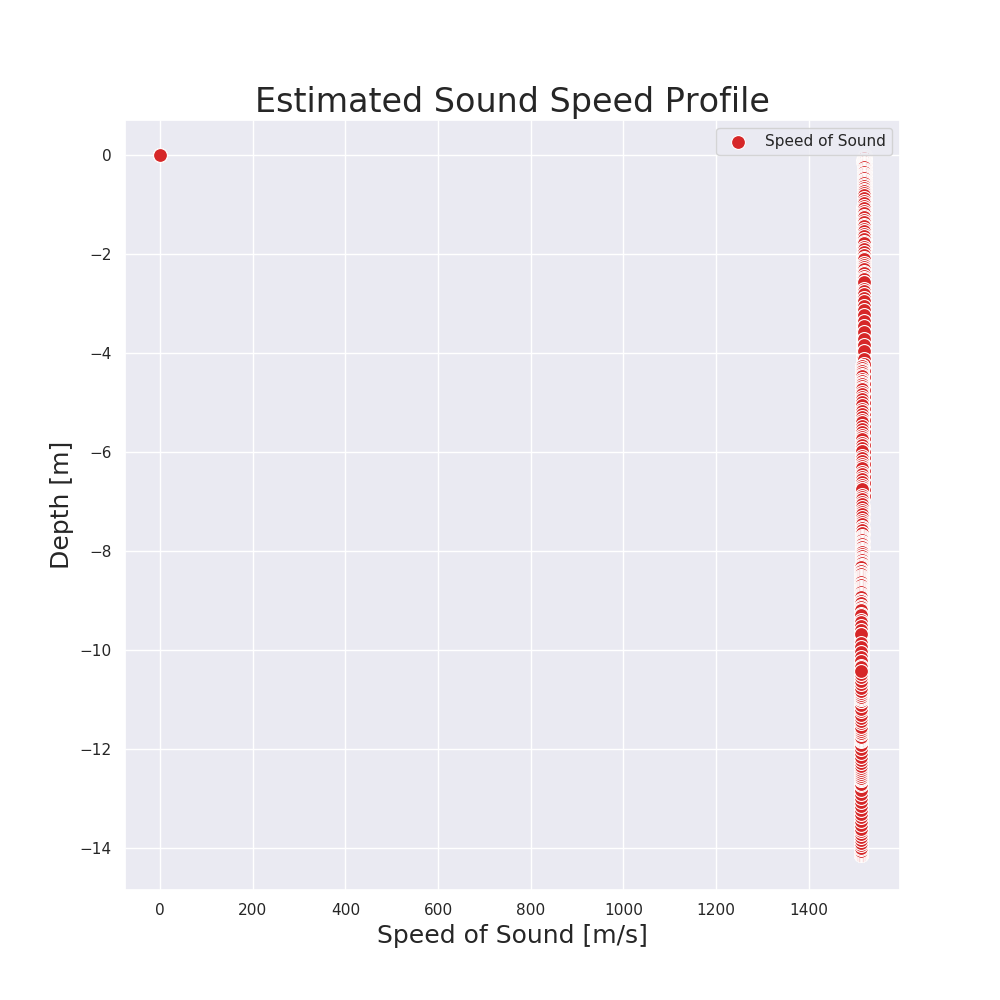

Text(0.5, 1.0, 'Estimated Sound Speed Profile')

In [90]:
# fig,ax = plt.subplots(figsize=(20,12))
# sns.scatterplot(ts.df.ros_timestamp,ts.df.angle_of_attack, color='tab:red', marker='o',label='AoA', s =30)
# sns.scatterplot(ts.df.ros_timestamp, ts.df.ahrs_pitch, color='tab:green', label='Pitch')
# plt.xlabel('Time [sec]')
# plt.ylabel('Angle')
# plt.title('Dynamic Angle of Attack', fontweight='bold')

# fig,ax = plt.subplots(figsize=(18,12))
# sns.scatterplot(ts.df.ros_timestamp, ts.df.speed_mag, color='tab:blue', label='Speed')

# fig,ax = plt.subplots(figsize=(12,12))
# sns.scatterplot(ts.df.ros_timestamp, ts.df.ahrs_pitch, color='tab:green', label='Pitch')
# sns.scatterplot(ts.df.ros_timestamp, ts.df.ctd_depth, label='depth')

# fig,ax = plt.subplots(figsize=(20,12))
# sns.scatterplot(ts.df.speed_mag,(ts.df.angle_of_attack), color='tab:red', marker='o',label='AoA', s =30)
# # sns.scatterplot(ts.df.ros_timestamp, ts.df.ahrs_pitch, color='tab:green', label='Pitch')
# plt.xlabel('Speed')
# plt.ylabel('Angle')
# plt.title('Dynamic Angle of Attack', fontweight='bold')

# plt.figure()
# plt.hist(np.abs(ts.df.angle_of_attack), bins = 'auto')

# fig,ax = plt.subplots(figsize=(12,12))
# sns.scatterplot(ts.df.ros_timestamp,ts.df.rel_vel_dvl_u, color='tab:red', marker='o',label='u_vel_dvl', s =30)
# sns.scatterplot(ts.df.ros_timestamp,ts.df.rel_vel_dvl_v, color='tab:green', marker='o',label='v_vel_dvl', s =30)
# sns.scatterplot(ts.df.ros_timestamp, ts.df.ahrs_pitch*(np.pi/180), color='tab:blue', label='Pitch')
# plt.title('Relative Velocities: DVL')

# fig,ax = plt.subplots(figsize=(12,12))
# sns.scatterplot(ts.df.ros_timestamp,ts.df.rel_vel_pressure_u, color='tab:red', marker='o',label='u_vel_press', s =30)
# sns.scatterplot(ts.df.ros_timestamp,ts.df.rel_vel_pressure_v, color='tab:green', marker='o',label='v_vel_press', s =30)
# sns.scatterplot(ts.df.ros_timestamp, ts.df.ahrs_pitch*(np.pi/180), color='tab:blue', label='Pitch')
# plt.title('Relative Velocities: Pressure')
title_font_size = 24
label_font_size = 18
fig,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(ts.df.ctd_speed_of_sound, ts.df.ctd_depth*-1, color='tab:red', \
    marker='o',label='Speed of Sound', s =100)
plt.xlabel('Speed of Sound [m/s]', fontsize=label_font_size)
plt.ylabel('Depth [m]', fontsize=label_font_size)
plt.title('Estimated Sound Speed Profile', \
    fontsize=title_font_size)


---
<a id='compute-water-column-currents'></a>
## Compute Water Column Currents


Num of Bottom Lock Pings: 10636
> Finished Estimating Water Column Currents!
Water Column (depth=54) 
|z =  0| V[   4,   2,   0]
|z =  2| V[   1,  -1,   0]
|z =  4| V[   2,   1,   0]
|z =  6| V[   1,   0,   0]
|z =  8| V[   0,   0,   0]
|z = 10| V[  -1,   1,   0]
|z = 12| V[  -1,   0,   0]
|z = 14| V[  -3,  -2,   0]
|z = 16| V[  -2,   2,   0]
|z = 18| V[  -3,   8,   0]
|z = 20| V[   7, -22,   0]
|z = 22| V[----,----,----]
|z = 24| V[----,----,----]
|z = 26| V[----,----,----]
|z = 28| V[----,----,----]
|z = 30| V[----,----,----]
|z = 32| V[----,----,----]
|z = 34| V[----,----,----]
|z = 36| V[----,----,----]
|z = 38| V[----,----,----]
|z = 40| V[----,----,----]
|z = 42| V[----,----,----]
|z = 44| V[----,----,----]
|z = 46| V[----,----,----]
|z = 48| V[----,----,----]
|z = 50| V[----,----,----]
|z = 52| V[----,----,----]



<IPython.core.display.Javascript object>


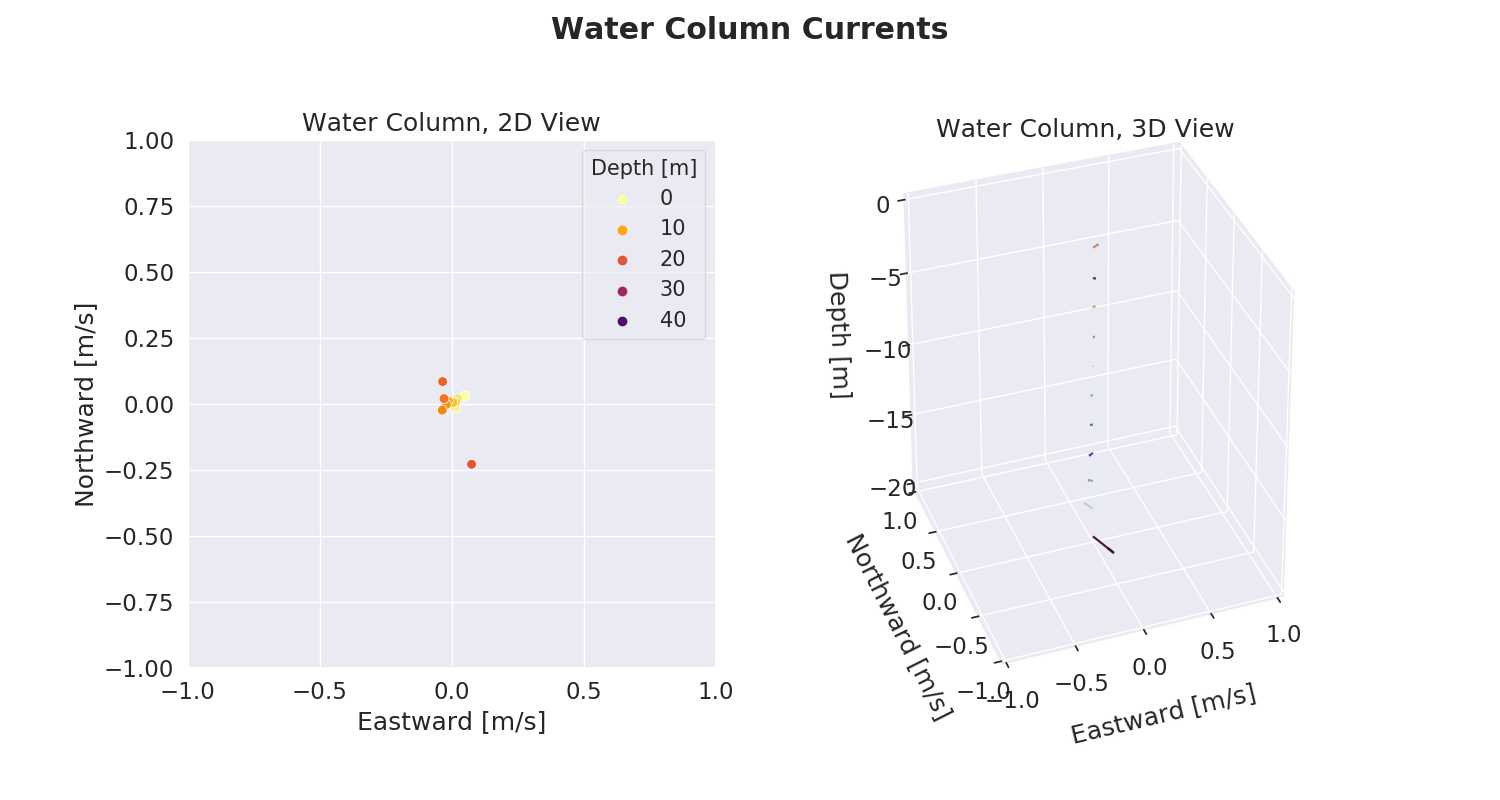

In [93]:
reload_modules()

btm_count = 0
# tuning parameters for working with DVL data 
pitch_bias           = 0
#pitch_bias           =  8    # [deg]   mounting pitch bias for the sonar
start_filter         =  0    # [bin #] avoid using the first number of bins
end_filter           =  1    # [bin #] avoid using the last number of bins 
voc_mag_filter       =  10.0  # [m/s]   filter out ocean current 
voc_delta_mag_filter =  0.5  # [m/s]   filter out deltas between layers
near_surface_filter  = 10   # [m]     ignore Vtw when near surface 
direction = 'descending'



# constants
DEG_TO_RAD = np.pi/180

# determine DVL parameters 
bin_len      = ts.df.depth_bin_length[0]
bin0_dist    = ts.df.bin0_distance[0]
bin_len      = np.cos(pitch_bias*DEG_TO_RAD)*bin_len
bin0_dist    = np.cos(pitch_bias*DEG_TO_RAD)*bin0_dist
max_range    = 40
max_depth    = int(np.max(ts.df.ctd_depth)+max_range)
x_beam       = 0
y_beam       = 1
# print(bin_len, bin0_dist, max_depth )

# intialize water column
water_column = VelocityShearPropagation.WaterColumn(
    bin_len=bin_len, 
    bin0_dist=bin0_dist,
    max_depth=max_depth,
    start_filter=start_filter,
    end_filter=end_filter,
    voc_mag_filter=voc_mag_filter,
    voc_delta_mag_filter=voc_delta_mag_filter,
)

# iterate over the DVL ensembles 
for t in range(len(ts.df)):

    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.ctd_depth[t]
    pitch = ts.df.ahrs_pitch[t]
    roll  = ts.df.ahrs_roll[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    #print(vtw_u, vtw_v)
    # extract Voc reference from bottom track velocity when available
#     if t < 10:
#         voc_ref = VelocityShearPropagation.OceanCurrent(0,0,0)
    if not np.isnan(ts.df.abs_vel_btm_u[t]):
        vog_u = ts.df.abs_vel_btm_u[t]
        vog_v = ts.df.abs_vel_btm_v[t]
        voc_u = vog_u - vtw_u
        voc_v = vog_v - vtw_v
        voc_ref = VelocityShearPropagation.OceanCurrent(voc_u, voc_v, 0)
        # print(vog_u, vog_v)
        btm_count = btm_count +1

    #### else if: (at surface and gps is available )
    # calculate voc_ref using surface drift
    else:
        voc_ref = VelocityShearPropagation.OceanCurrent()
        
    # add shear nodes for each DVL depth bin that meet the filter criteria
    num_good_vel_bins = ts.df.num_good_vel_bins[t]
    if num_good_vel_bins > start_filter+end_filter:        
        
        # determine if glider ascending or descending
        delta_z = ts.df.delta_z[t] 
        if delta_z > 0:
            direction = 'descending'
        else:
            direction = 'ascending'

        # build list of velocity shears to add as ShearNode to water column
        delta_voc_u = []
        delta_voc_v = []

        # add all valid DVL bins to the shear list 
        #   + filtering of DVL bins will occur in the `add_shear_node` call
        for bin_num in range(int(num_good_vel_bins)):

            # retrieve the shear list from the DVL data 
            x_var = ts.get_profile_var_name('velocity', bin_num, x_beam)
            y_var = ts.get_profile_var_name('velocity', bin_num, y_beam)
            # print(x_var,y_var)
            dvl_x = ts.df[x_var][t]
            dvl_y = ts.df[y_var][t]

            # compute delta between dead-reckoned through-water velocity & DVL
            delta_voc_u.append(vtw_u - (dvl_x))
            delta_voc_v.append(vtw_v - (dvl_y))

        shear_list = [VelocityShearPropagation.OceanCurrent(
                        delta_voc_u[i], 
                        delta_voc_v[i], 
                        0) 
                      for i in range(len(delta_voc_u))]

        # add shear node to the water column with shear list information 
        if len(shear_list):
            water_column.add_shear_node(
                z_true=depth,
                t=t,
                shear_list=shear_list,
                voc_ref=voc_ref,
                direction=direction,
                pitch=pitch,
                roll=roll,
            )

    # add voc_ref measurement to the water column even if shear list is empty  
    elif not voc_ref.is_none():
        water_column.add_shear_node(
            z_true=depth,
            t=t,
            shear_list=[],
            voc_ref=voc_ref,
            direction=direction,
            pitch=pitch,
            roll=roll,
        )

print('Num of Bottom Lock Pings: ' + str(btm_count))
voc_u_list,voc_v_list,voc_w_list, z_list = water_column.compute_averages()
print("> Finished Estimating Water Column Currents!")
print(water_column.averages_to_str())
dvl_plotter.plot_water_column_currents(voc_u_list, voc_v_list, voc_w_list, z_list, save_name='tmp-water-column.png')

In [94]:

# fig,ax = plt.subplots(figsize=(12,12))
# sns.scatterplot(ts.df.num_good_vel_bins,ts.df.ctd_depth*-1, color='tab:red', marker='o', s =30)
# plt.title('Good Vel Bins Vs Depth')

# fig,ax = plt.subplots(figsize=(12,12))
# sns.scatterplot(voc_u_list, voc_v_list, hue=z_list)
# plt.xlabel('East Velocity')
# plt.ylabel('North Velocity')

---
<a id='compute-dvl-odometry'></a>
## Compute DVL-Odometry

In [95]:
#TODO add in ability to synthetically remove bottom lock
# Since DVL data is at 1 Hz, bottom lock cutoff is essentially num of seconds since start of mission 
#    where use of bottom-lock in DVL-ODO (even if available) is not used
bottom_lock_cutoff = 0

#counters to see how algorithm works without bottom lock
count_vtw_est_w_current = 0
count_vtw_est = 0
count_voc_only = 0

# How long (in mins) will algorithm accept ocean current estimates i.e. forgetting factor
ocean_current_time_filter = 12.5 # mins
MIN_NUM_NODES = 12

# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x_lmc = df_dbd.m_x_lmc[t]
        dbd_origin_y_lmc = df_dbd.m_y_lmc[t]
        dbd_origin_m_lat = df_dbd.m_lat[t]
        dbd_origin_m_lon = df_dbd.m_lon[t]
        break

dbd_utm_x_origin, dbd_utm_y_origin, _, zone_letter = get_utm_coords_from_glider_lat_lon(
    dbd_origin_m_lat, 
    dbd_origin_m_lon
)

# initialize list for new odometry
rel_pos_x = [0]
rel_pos_y = [0]
rel_pos_x_no_BL = [0]
rel_pos_y_no_BL = [0]
rel_pos_z = [0]
delta_x_list = [0]
delta_y_list = [0]
vel_list_x = []
vel_list_y = []
u_list     = []
v_list     = []
# set flag for setting GPS updates
flag_gps_fix_at_surface = False
# set counter for synthetically removing bottom lock
bottom_lock_switch = 0

# iterate through the dive file to update odometry
for t in range(1,len(ts.df)):
    bottom_lock_switch = bottom_lock_switch + 1
    time         = ts.df.ros_timestamp[t]
    prev_x       = rel_pos_x[-1]
    prev_y       = rel_pos_y[-1]
    prev_x_no_BL = rel_pos_x_no_BL[-1]
    prev_y_no_BL = rel_pos_y_no_BL[-1]
    delta_t      = ts.df.delta_t[t]
    depth        = ts.df.ctd_depth[t]
    
    # only use Vtw from pressure sensor when submerged 
    depth = ts.df.ctd_depth[t]
    if depth > near_surface_filter:
        vtw_u = ts.df.rel_vel_pressure_u[t]
        vtw_v = ts.df.rel_vel_pressure_v[t]
        flag_gps_fix_at_surface = False
    # otherwise use the DVL to estimate the Vtw at the surface
    else:
        vtw_u = ts.df.rel_vel_dvl_u[t]
        vtw_v = ts.df.rel_vel_dvl_v[t]
    
    # retrieve over ground velocity from DVL in bottom track 
    vog_u = ts.df.abs_vel_btm_u[t]
    vog_v = ts.df.abs_vel_btm_v[t]
    #################################################################
    # retrieve ocean current estimate from water column 
    good_node_list = []
    count = 0
    cum_voc_u = 0
    cum_voc_v = 0
    # Extract all shear nodes at current depth
    wc_depth = water_column.get_wc_bin(depth)
    node_list = water_column.get_voc_at_depth(wc_depth)

    #Iterate through shear nodes at depth
    for shear_node in node_list:
        voc = shear_node.voc
        if not(voc.is_none()):
            # filter out large values when computing averages
            if voc.mag < voc_mag_filter:
                good_node_list.append(shear_node)
    ####################################################################
    if (len(good_node_list) > 0):
            for i in range(len(good_node_list)):
                if i == 0:
                    count += 1
                    cum_voc_u += good_node_list[0].voc.u
                    cum_voc_v += good_node_list[0].voc.v
                elif (i <= MIN_NUM_NODES):
                    count += 1
                    cum_voc_u += good_node_list[i].voc.u
                    cum_voc_v += good_node_list[i].voc.v
                else: 
                    time_between_current_estimates = good_node_list[i].t - good_node_list[0].t
                    if time_between_current_estimates > (ocean_current_time_filter*60):
                        count += 1 
                        cum_voc_u += good_node_list[i].voc.u
                        cum_voc_v += good_node_list[i].voc.v
            #voc_avg = OceanCurrent(cum_voc_u/count, cum_voc_v/count, 0)
            voc_u = cum_voc_u/count
            voc_v = cum_voc_v/count
            u_list.append(voc_u)
            v_list.append(voc_v)             
    else:
        voc_u = np.nan
        voc_v = np.nan
        u_list.append(voc_u)
        v_list.append(voc_v)

    #################################################################
    # initialize delta values to zero
    delta_x, delta_y = 0,0
    # CASE 1: use bottom track overground velocity if available
    if (not np.isnan(vog_u)):
        delta_x = vog_u*delta_t
        delta_y = vog_v*delta_t
        vel_list_x.append(vog_u)
        vel_list_y.append(vog_v)
    
    # CASE 2: use through water velocity and ocean current estimate if available
    elif (not np.isnan(vtw_u)) and (not np.isnan(voc_u)):
            delta_x = (vtw_u + voc_u)*delta_t
            delta_y = (vtw_v + voc_v)*delta_t
            vel_list_x.append(vtw_u + voc_u)
            vel_list_y.append(vtw_v + voc_v)
    # CASE 3: use through water velocity if available
    elif (not np.isnan(vtw_u)):
            delta_x = vtw_u*delta_t
            delta_y = vtw_v*delta_t
            vel_list_x.append(vtw_u)
            vel_list_y.append(vtw_v)
    # CASE 4: use ocean current estimate if available
    elif (not np.isnan(voc_u)):
            delta_x = voc_u*delta_t
            delta_y = voc_v*delta_t
            vel_list_x.append(voc_u)
            vel_list_y.append(voc_v)

    # set current position to DVL odometry result 
    cur_x = delta_x + prev_x
    cur_y = delta_y + prev_y
    
    ##################################################################
    # Synthetically remove Bottom-Lock

    # initialize delta values to zero
    delta_x_no_BL, delta_y_no_BL = 0,0
    if bottom_lock_switch < bottom_lock_cutoff:
    # CASE 1: use bottom track overground velocity if available
        if (not np.isnan(vog_u)):
            delta_x_no_BL = vog_u*delta_t
            delta_y_no_BL = vog_v*delta_t
        # CASE 2: use through water velocity and ocean current estimate if available
        elif (not np.isnan(vtw_u)) and (not np.isnan(voc_u)):
                delta_x_no_BL = (vtw_u + voc_u)*delta_t
                delta_y_no_BL = (vtw_v + voc_v)*delta_t
        # CASE 3: use through water velocity if available
        elif (not np.isnan(vtw_u)):
                delta_x_no_BL = vtw_u*delta_t
                delta_y_no_BL = vtw_v*delta_t
        # CASE 4: use ocean current estimate if available
        elif (not np.isnan(voc_u)):
                delta_x_no_BL = voc_u*delta_t
                delta_y_no_BL = voc_v*delta_t
    else:
        # CASE 2: use through water velocity and ocean current estimate if available
        if (not np.isnan(vtw_u)) and (not np.isnan(voc_u)):
                delta_x_no_BL = (vtw_u + voc_u)*delta_t
                delta_y_no_BL = (vtw_v + voc_v)*delta_t 
                count_vtw_est_w_current += 1
        # CASE 3: use through water velocity if available
        elif (not np.isnan(vtw_u)):
                delta_x_no_BL = vtw_u*delta_t
                delta_y_no_BL = vtw_v*delta_t
                count_vtw_est += 1
        # CASE 4: use ocean current estimate if available
        elif (not np.isnan(voc_u)):
                delta_x_no_BL = voc_u*delta_t
                delta_y_no_BL = voc_v*delta_t
                count_voc_only += 1

    # set current position to DVL odometry result 
    cur_x_no_BL = delta_x_no_BL + prev_x_no_BL
    cur_y_no_BL = delta_y_no_BL + prev_y_no_BL
    # overide currernt position with m_x_lmc/m_y_lmc when glider has been at surface for 10 seconds and then dives back down past 0.5m (last position given by m_x_lmc)
    # override current position if GPS fix is given 
    # if depth < near_surface_filter:
    #     cur_time = datetime.datetime.fromtimestamp(time+time_zone_shift)
    #     cur_dbd  = df_dbd[str(cur_time):].copy()
    #     if (len(cur_dbd.m_gps_x_lmc) != 0):
    #         if not np.isnan(cur_dbd.m_gps_x_lmc[0]):
    #             cur_x = cur_dbd.m_gps_x_lmc[0] - dbd_origin_x_lmc
    #             cur_y = cur_dbd.m_gps_y_lmc[0] - dbd_origin_y_lmc
    #             cur_x_no_BL = cur_x
    #             cur_y_no_BL  = cur_y
    #             flag_gps_fix_at_surface = True
    #             vel_list_x.append(cur_dbd.m_vx_lmc[0])
    #             vel_list_y.append(cur_dbd.m_vy_lmc[0])
    
    if depth < near_surface_filter:
        cur_time = datetime.datetime.fromtimestamp(time+time_zone_shift)
        cur_dbd  = df_dbd[str(cur_time):].copy()
        if (len(cur_dbd.m_gps_lat) != 0):
            if not np.isnan(cur_dbd.m_gps_lat[0]):
                cur_x, cur_y,_,_ = get_utm_coords_from_glider_lat_lon(cur_dbd.m_gps_lat[0],cur_dbd.m_gps_lon[0])
                cur_x = cur_x - dbd_utm_x_origin
                cur_y = cur_y - dbd_utm_y_origin
                cur_x_no_BL = cur_x
                cur_y_no_BL  = cur_y
                flag_gps_fix_at_surface = True
                vel_list_x.append(cur_dbd.m_vx_lmc[0])
                vel_list_y.append(cur_dbd.m_vy_lmc[0])
    
    # update the odometry list of positions
    rel_pos_x.append(cur_x)
    rel_pos_y.append(cur_y)
    rel_pos_x_no_BL.append(cur_x_no_BL)
    rel_pos_y_no_BL.append(cur_y_no_BL)
    rel_pos_z.append(depth)
    delta_x_list.append(delta_x)
    delta_y_list.append(delta_y)
    
# add new odomety to the data frame
ts.df['rel_pos_x_no_BL'] = rel_pos_x_no_BL
ts.df['rel_pos_y_no_BL'] = rel_pos_y_no_BL
ts.df['rel_pos_x'] = rel_pos_x
ts.df['rel_pos_y'] = rel_pos_y
ts.df['rel_pos_z'] = rel_pos_z
ts.df['delta_x']   = delta_x_list
ts.df['delta_y']   = delta_y_list

print("> Finished Calculating Odometry!")

> Finished Calculating Odometry!


In [96]:
# No Bottom Lock
print('DVL-ODO with no bottom-lock used a Vog est based on Vtw + V_oc %d times, just a Vtw est %d times, and just Voc %d times.' % (count_vtw_est_w_current, count_vtw_est, count_voc_only) )

DVL-ODO with no bottom-lock used a Vog est based on Vtw + V_oc 10537 times, just a Vtw est 0 times, and just Voc 111 times.


---
## Plot Navigation Results 

### Produce UTM and Lat/Lon Re-Nav Estimates

In [97]:
# extract start_t position "origin" from the glider flight data 

def get_utm_coords_from_glider_lat_lon(m_lat, m_lon):
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = np.abs(m_lon) % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon + lon_min)/MIN_OFFSET - lon_min/SECS_IN_MIN
    utm_pos  = utm.from_latlon(lat_dec, lon_dec)
    easting  = round(utm_pos[0],2)
    northing = round(utm_pos[1],2)
    zone     = utm_pos[2]
    zone_letter  = utm_pos[3]
    return(easting, northing, zone, zone_letter)

# Function for converting DDMM.XX lat and lon to DD.XXX
#TODO need to make this function robust to all locations right now its specific to positive latitudes and negative longitude
def get_utm_coords_from_glider_lat_lon(m_lat, m_lon):
    SECS_IN_MIN = 60
    MIN_OFFSET = 100
    lat_min  = m_lat % MIN_OFFSET 
    lon_min  = np.abs(m_lon) % MIN_OFFSET 
    lat_dec  = (m_lat - lat_min)/MIN_OFFSET + lat_min/SECS_IN_MIN
    lon_dec  = (m_lon + lon_min)/MIN_OFFSET - lon_min/SECS_IN_MIN
    try:
        utm_pos  = utm.from_latlon(lat_dec, lon_dec)
        easting  = round(utm_pos[0],2)
        northing = round(utm_pos[1],2)
        zone     = utm_pos[2]
        zone_letter  = utm_pos[3]
    except:
        easting = np.nan
        northing = np.nan
        zone = None
        zone_letter = None
    return(easting, northing, zone, zone_letter)

for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x_lmc = df_dbd.m_x_lmc[t]
        dbd_origin_y_lmc = df_dbd.m_y_lmc[t]
        dbd_origin_m_lat = df_dbd.m_lat[t]
        dbd_origin_m_lon = df_dbd.m_lon[t]
        break

# dbd_origin_m_lat_DD, dbd_origin_m_lon_DD = decimal_minutes_to_decimal_degrees(dbd_origin_m_lat, dbd_origin_m_lon)

# Convert starting lat lon to UTM
dbd_origin_utm_x, dbd_origin_utm_y, zone_number, zone_letter = get_utm_coords_from_glider_lat_lon(
    dbd_origin_m_lat, 
    dbd_origin_m_lon
)

utm_dr_x = []
utm_dr_y = []
utm_gps_x = []
utm_gps_y = []
for i in range(0,len(df_dbd.m_lat)):
    utm_x, utm_y,_,_ = get_utm_coords_from_glider_lat_lon(df_dbd.m_lat[i], df_dbd.m_lon[i])
    utm_x_gps, utm_y_gps,_,_ = get_utm_coords_from_glider_lat_lon(df_dbd.m_gps_lat[i], df_dbd.m_gps_lon[i])
    utm_dr_x.append(utm_x)
    utm_dr_y.append(utm_y)
    utm_gps_x.append(utm_x_gps)
    utm_gps_y.append(utm_y_gps)


# Generate DVL-ODO estimate of position in UTM coordinates
rel_pos_x_utm = (ts.df['rel_pos_x'] + dbd_origin_utm_x)
rel_pos_y_utm = (ts.df['rel_pos_y'] + dbd_origin_utm_y)

# UTM
df_dbd['utm_dr_x']      = utm_dr_x
df_dbd['utm_dr_y']      = utm_dr_y
df_dbd['utm_gps_x']     = utm_gps_x
df_dbd['utm_gps_y']     = utm_gps_y
ts.df['rel_pos_x_utm']  = rel_pos_x_utm
ts.df['rel_pos_y_utm']  = rel_pos_y_utm

# Convert DVL-ODO estimate of position to lat/lon
rel_pos_y_lat, rel_pos_x_lon = utm.to_latlon(ts.df.rel_pos_x_utm, ts.df.rel_pos_y_utm, zone_number, zone_letter)
m_lat_DD, m_lon_DD = utm.to_latlon(df_dbd.utm_dr_x, df_dbd.utm_dr_y, zone_number, zone_letter)
m_lat_GPS, m_lon_GPS = utm.to_latlon(df_dbd.utm_gps_x, df_dbd.utm_gps_y, zone_number, zone_letter)

# Lat/Lon in Decimal Degrees which matches how utm library converts utm to lat/lon
df_dbd['m_lat_DD']       = m_lat_DD
df_dbd['m_lon_DD']       = m_lon_DD
df_dbd['m_lat_gps_DD']   = m_lat_GPS
df_dbd['m_lon_gps_DD']   = m_lon_GPS
ts.df['rel_pos_lon']     = rel_pos_x_lon
ts.df['rel_pos_lat']     = rel_pos_y_lat


# plt.figure()
# plt.plot(m_lon_DD, m_lat_DD)
# plt.plot(m_lon_GPS, m_lat_GPS, '*')
# plt.plot(rel_pos_x_lon, rel_pos_y_lat, '.')
# # plt.axis('equal')


# s = 0
# e = -1
# plt.figure()
# plt.plot(df_dbd.m_lon[s:e], df_dbd.m_lat[s:e])
# plt.plot(df_dbd.m_gps_lon[s:e], df_dbd.m_gps_lat[s:e])
# plt.plot(dbd_origin_m_lon, dbd_origin_m_lat, '+')
# plt.plot(-6701.277, 1757.534, '*')

# plt.figure()
# plt.plot(df_dbd.m_x_lmc, df_dbd.m_y_lmc)
# plt.plot(df_dbd.m_gps_x_lmc, df_dbd.m_gps_y_lmc)

# plt.figure()
# plt.plot(ts.df.rel_pos_lon, ts.df.rel_pos_lat)

# print(dbd_origin_m_lat, dbd_origin_m_lon)
# print(dbd_origin_m_lat_DD, dbd_origin_m_lon_DD)
# print(dbd_origin_utm_x, dbd_origin_utm_y)
# print(zone_letter, zone_number)


<IPython.core.display.Javascript object>


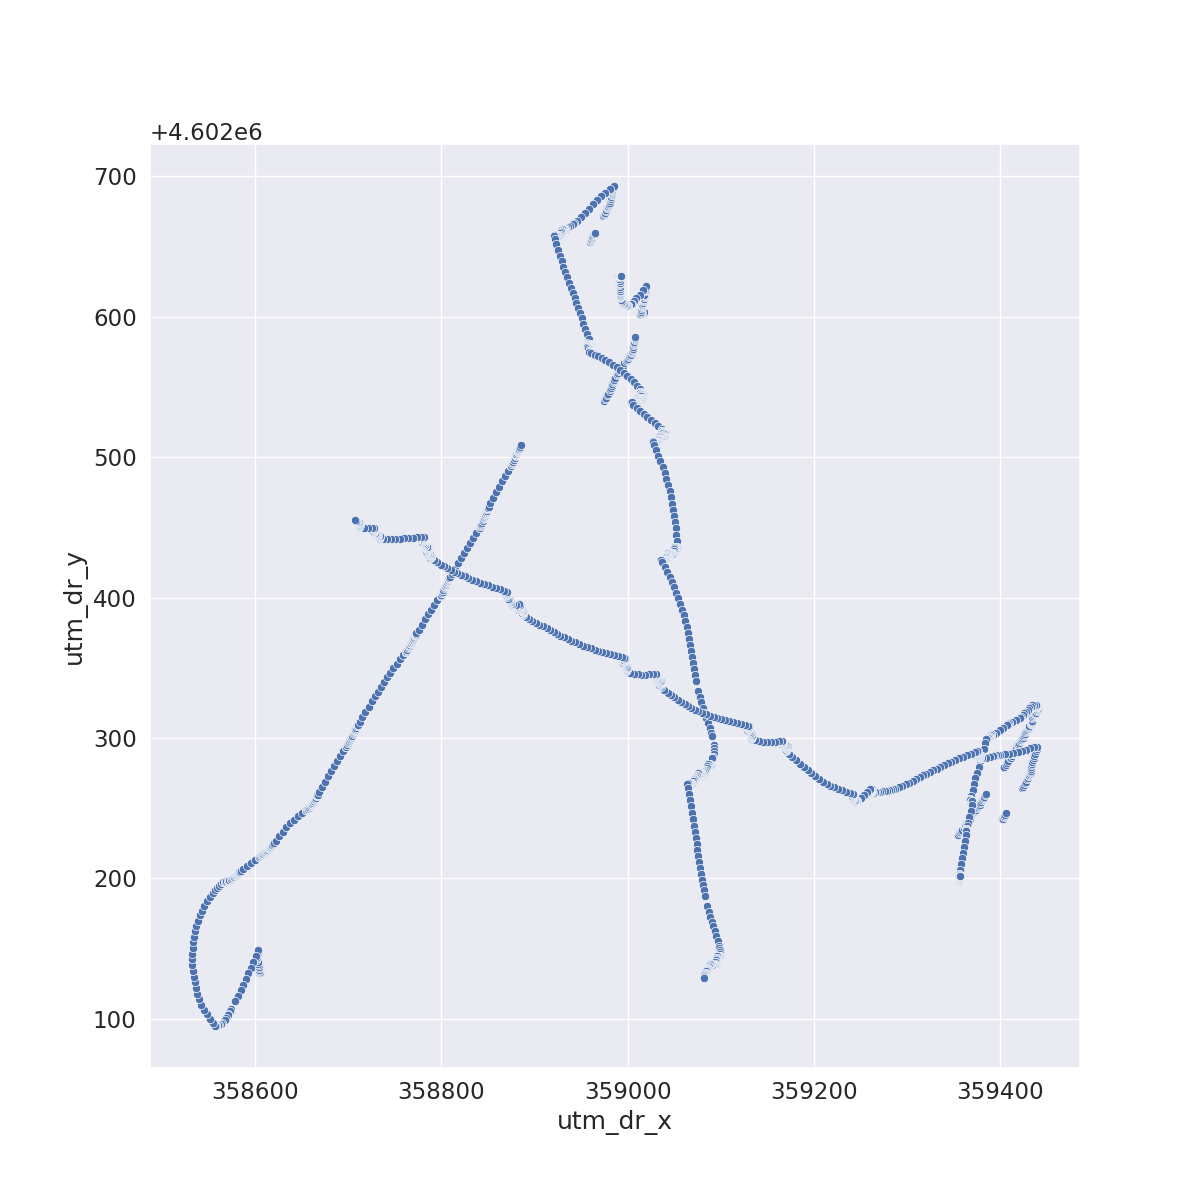

In [98]:
fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale = 1.5)
sns.scatterplot(df_dbd.utm_dr_x,df_dbd.utm_dr_y)

In [99]:
# March 17th dive 6 -- LAST GPS POINT pulled from navionics app
# ABORT due to overtime caused data to stop recording
# last_lon = -6701.277
# last_lat = 1757.534

# last_lat, last_lon =  decimal_minutes_to_decimal_degrees(last_lat, last_lon)
# print(last_lat, last_lon)

# last_lat, last_lon, _, _  = utm.from_latlon(last_lat, last_lon)
# print(last_lat, last_lon)
# y_gps_last = last_lon - dbd_origin_utm_y + dbd_origin_y_lmc
# x_gps_last = last_lat - dbd_origin_utm_x + dbd_origin_x_lmc
# print(x_gps_last, y_gps_last)
# x_gps_last = [x_gps_last, x_gps_last-1]
# y_gps_last = [y_gps_last, y_gps_last-1]
# print(x_gps_last, y_gps_last)

<IPython.core.display.Javascript object>


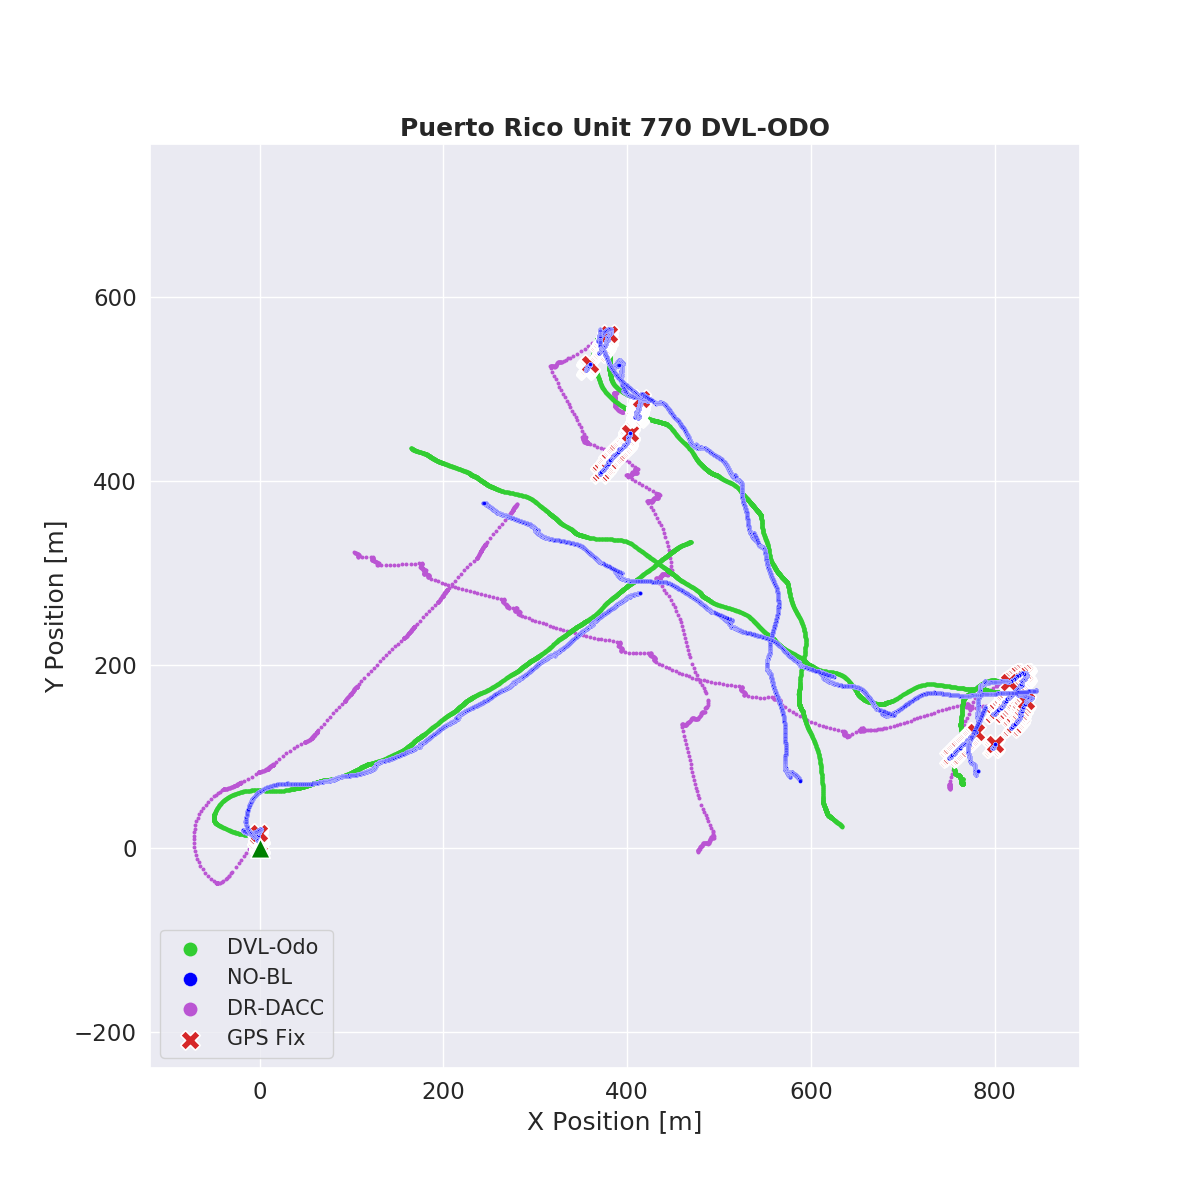

In [100]:
fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale = 1.5)
linewidth = 8
plt_bg = True

sns.scatterplot(
    ts.df.rel_pos_x, # - dbd_origin_x_lmc, 
    ts.df.rel_pos_y,# - dbd_origin_y_lmc, 
    linewidth=0, 
    color='limegreen', 
    label='DVL-Odo',
    s=linewidth, 
    zorder=2,
)
odos=1

sns.scatterplot(
    ts.df.rel_pos_x_no_BL,
    ts.df.rel_pos_y_no_BL,
    color='blue', 
    label='NO-BL',
    s=linewidth, 
    zorder=4,
)
odos=4

sns.scatterplot(
    ts.df.rel_pos_x_no_BL[bottom_lock_cutoff:bottom_lock_cutoff+1],
    ts.df.rel_pos_y_no_BL[bottom_lock_cutoff:bottom_lock_cutoff+1],
    marker = '^',
    s=200,
    color = 'green', 
    zorder=5,
)
odos=5

sns.scatterplot(
    x=df_dbd.utm_dr_x - dbd_origin_utm_x,
    y=df_dbd.utm_dr_y - dbd_origin_utm_y,
    color='mediumorchid',
    label='DR-DACC',
    linewidth=0,
    s=linewidth,
    data=df_dbd,
    zorder=1,
)
odos=2

sns.scatterplot(
    x=df_dbd.utm_gps_x - dbd_origin_utm_x, 
    y=df_dbd.utm_gps_y - dbd_origin_utm_y,
    marker='X',
    color='tab:red', 
    s=200,
    label='GPS Fix',
    data=df_dbd,
    zorder=3,
)
odos=3

lgnd = plt.legend(loc='lower left', fontsize='small')
for i in range(odos):
    lgnd.legendHandles[i]._sizes = [100]

plt.axis('equal')
xlim=ax.get_xlim()
ylim=ax.get_ylim()

MFTAN_bg = np.array(bathy_df.slope_list)
bg_threshold = 30
MFTAN_bg[MFTAN_bg>bg_threshold] = bg_threshold
MFTAN_bg[0] = 3*np.nanmax(MFTAN_bg)

if plt_bg:
    sns.scatterplot(
        bathy_df.utm_x_list - dbd_origin_utm_x,
        bathy_df.utm_y_list - dbd_origin_utm_y,
        MFTAN_bg,
        marker='s',
        ax=ax,
        s=200,
#         s=80,
#         s=20,
        palette="gray_r",
        linewidth=0,
        zorder=0,
        legend=False,
    )
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xlabel('X Position [m]')
plt.ylabel('Y Position [m]')
plt.title('Puerto Rico Unit 770 DVL-ODO', fontweight='bold')
#plt.suptitle('MF-TAN: Dive %s '%dive_label +'-- Map Var Resolution: %s'%map_var_resolution,  fontweight='bold')
#plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
#plt.close()
#print('> Done plotting!')
plt.show()

# ts.df.head()
# plt.figure()
# plt.plot(ts.df.btm_beam0_range)
# plt.plot(ts.df.btm_beam1_range)
# plt.plot(ts.df.btm_beam2_range)
# plt.plot(ts.df.btm_beam3_range)

# plt.figure()
# plt.plot(ts.df.ahrs_pitch)

# plt.figure()
# plt.plot(ts.df.ahrs_roll)

# plt.figure()
# plt.plot(ts.df.ahrs_heading)
# plt.figure()
# plt.plot(df_dbd.m_heading * 180/3.14, 'r')

2022-06-28 14:06:00.331791
2022-06-28 14:38:26.499419


<IPython.core.display.Javascript object>


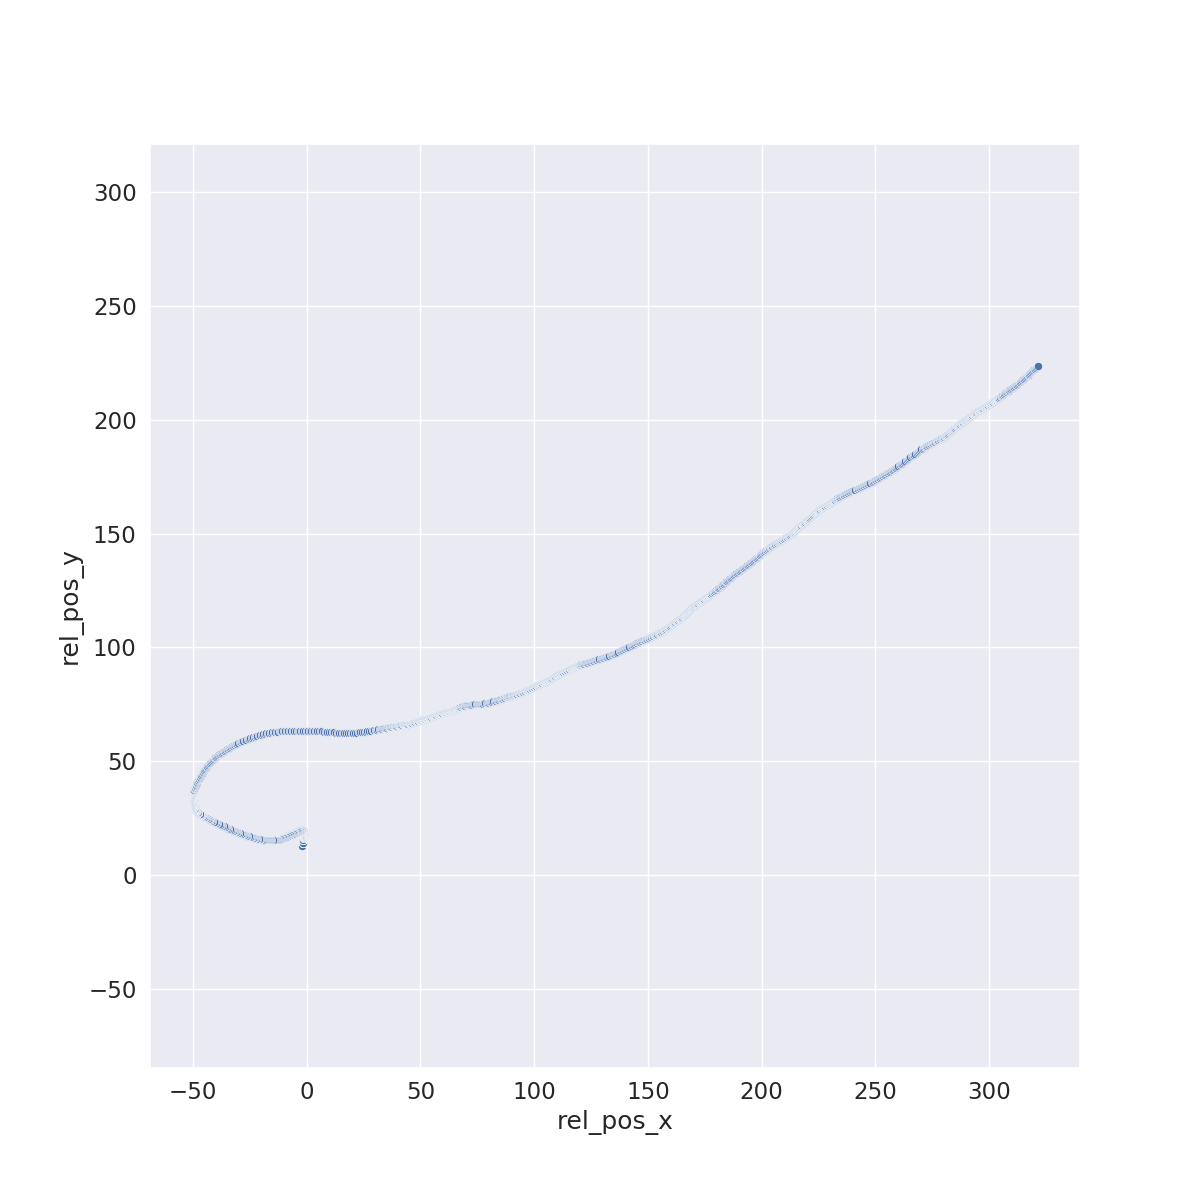

<IPython.core.display.Javascript object>


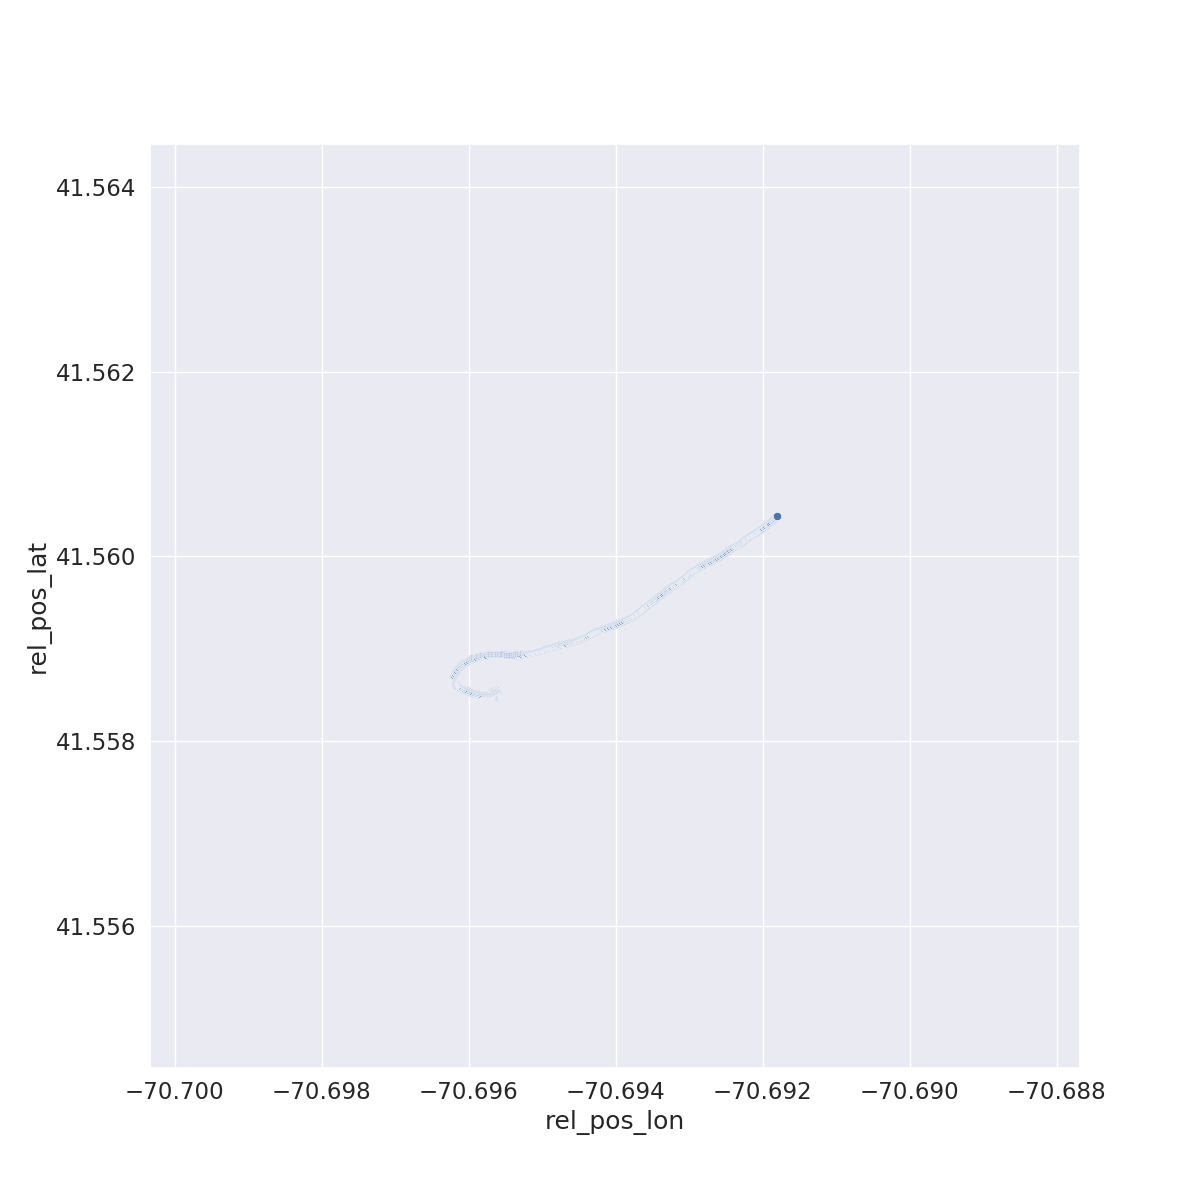

x_vel_avg:  0.1818376849261457
y_vel_avg:  0.11712701035789423
Direction: (from + x axis):  43.028114365332044


In [101]:
# start_dvl = dvl_raw_df_new.index.get_loc(ctd_start, method='nearest')
# end_dvl = dvl_raw_df_new.index.get_loc(ctd_end, method='nearest')
print(datetime.datetime.fromtimestamp(ts.df.ros_timestamp[1859]))
print(datetime.datetime.fromtimestamp(ts.df.ros_timestamp[3805]))

leg1_start = 65 
leg1_end = 1858
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(ts.df.rel_pos_x[leg1_start:leg1_end], ts.df.rel_pos_y[leg1_start:leg1_end])
plt.axis('equal')
fig, ax = plt.subplots(figsize=(12,12))
sns.scatterplot(ts.df.rel_pos_lon[leg1_start:leg1_end], ts.df.rel_pos_lat[leg1_start:leg1_end])
print('x_vel_avg: ', np.mean(ts.df.abs_vel_btm_u[leg1_start:leg1_end]))
print('y_vel_avg: ', np.mean(ts.df.abs_vel_btm_v[leg1_start:leg1_end]))
x_vel_avg = np.mean(ts.df.abs_vel_btm_u[leg1_start:leg1_end])
y_vel_avg = np.mean(ts.df.abs_vel_btm_v[leg1_start:leg1_end])
print('Direction: (from + x axis): ' ,np.tan(y_vel_avg/x_vel_avg)*180/np.pi)

# leg2_start = 1859
# leg2_end = 3651
# fig, ax = plt.subplots(figsize=(12,12))
# sns.scatterplot(ts.df.rel_pos_x[leg2_start:leg2_end], ts.df.rel_pos_y[leg2_start:leg2_end])
# # fig, ax = plt.subplots(figsize=(12,12))
# # sns.scatterplot(ts.df.rel_pos_lon[leg1_start:leg1_end], ts.df.rel_pos_lat[leg1_start:leg1_end])
# plt.axis('equal')
# print('x_vel_avg: ', np.mean(ts.df.abs_vel_btm_u[leg2_start:leg2_end]))
# print('y_vel_avg: ', np.mean(ts.df.abs_vel_btm_v[leg2_start:leg2_end]))
# x_vel_avg = np.mean(ts.df.abs_vel_btm_u[leg2_start:leg2_end])
# y_vel_avg = np.mean(ts.df.abs_vel_btm_v[leg2_start:leg2_end])
# print('Direction: (from + x axis): ' ,np.tan(y_vel_avg/x_vel_avg)*180/np.pi)


# h1 = ts.df['btm_beam0_range']
# h2 = ts.df['btm_beam1_range']
# h3 = ts.df['btm_beam2_range']
# h4 = ts.df['btm_beam3_range']
# depth = ts.df['ctd_depth']
# altitude = depth*-1 - ((h1*h2)/(h1 + h2) + (h3*h4)/(h3 + h4))
# fig, ax = plt.subplots(figsize=(12,12))
# sns.scatterplot(ts.df.ros_timestamp,altitude)
# print('Mean Water Depth: ', np.mean(np.abs(altitude)))
# plt.title('Ocean Floor from DVL')


In [102]:
reload_modules()
# Plot profile and odometry and DR
path_to_save_to = '/tmp/figs/'
# path_to_save_to = '/home/gburgess/figs/prelim/mar17/' + selected_dive + '/'
bathy_df_plot = pd.read_csv('/home/glider-sim/dvl-nav/data/field_data/puerto_rico/bathy/puertoRico_TS1-1.csv')

dvl_plotter_unit770_PR.plot_profile_and_odometry_and_dr(ts, df_dbd, bathy_df, voc_u_list, voc_v_list, voc_w_list, z_list, save_name=path_to_save_to + selected_dive + '_profile_odo_dr.png')


FileNotFoundError: [Errno 2] No such file or directory: '/home/glider-sim/dvl-nav/data/field_data/puerto_rico/bathy/puertoRico_TS1-1.csv'

In [ ]:
dvl_plotter_unit770_PR.plot_water_column_currents(voc_u_list, voc_v_list, voc_w_list, z_list, save_name=path_to_save_to + selected_dive + '_water_column.png')


---
<a id='multi-factor-terrain-based-navigation'></a>
## Multi-Factor Terrain Based Navigation (MF-TAN)

In [ ]:
reload_modules()

# constants
JANUS_ANGLE = 30
DEG_TO_RAD  = np.pi/180
RAD_TO_DEG  = 1/DEG_TO_RAD
sin_janus   = np.sin(JANUS_ANGLE*DEG_TO_RAD)
cos_janus   = np.cos(JANUS_ANGLE*DEG_TO_RAD)
min_valid_slant_ranges = 3 

# AUG parameters
# BIAS_PITCH   = 12.5  # [deg]
BIAS_PITCH   =  0.0  # [deg]
BIAS_ROLL    =  0.0  # [deg]
BIAS_HEADING =  0.0  # [deg]

# # TAN parameters 1st attempt Puerto Rico Mar 17
DVL_ODO_DRIFT = 0.60 #Heuristic that determines growth of uncertaintyh based on worst-case DVL-ODO performance history
TAN_RED_DRIFT = 0.70 #Every time there is a a valid MF-TAN fix, reduces r (positional uncertainty) by 30%
TAN_WEIGHT    = 0.5

# # TAN parameters
############################
# Long Dive (Dive A) ########
# DVL_ODO_DRIFT = 0.15 #Heuristic that determines growth of uncertaintyh based on worst-case DVL-ODO performance history
# DVL_ODO_DRIFT = 0.60
# TAN_RED_DRIFT = 0.70 #Every time there is a a valid MF-TAN fix, reduces r (positional uncertainty) by 30%
# TAU_DEPTH     = 2
# TAU_SLOPE     = 2
# TAU_ORIENT    = 4
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4
# TAU_DEPTH     = 5
# TAU_SLOPE     = 15
# TAU_ORIENT    = 10
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4
# TAN_WEIGHT    = 0.5

# ###########################
# # Short Dive (Dive F) #######
# DVL_ODO_DRIFT = 0.20
# TAN_RED_DRIFT = 0.90
# TAU_DEPTH     = 1
# TAU_SLOPE     = 20
# TAU_ORIENT    = 30
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4

#############################
# TEMPORARY #################
# DVL_ODO_DRIFT = 0.20
# TAN_RED_DRIFT = 0.90
# TAU_DEPTH     = 1
# TAU_SLOPE     = 0
# TAU_ORIENT    = 0
# MIN_PITCH_FOR_ORIENT = 10
# TAN_WEIGHT    = 0.4

################# TEMPORARY --> NEED to UNDERSTAND FULL EFFECT
# factor_depth_point  = 288.39 
# factor_slope_point  = 30.08
# factor_orient_point = 129.23


# heading offsets for the four DVL beams
beam_heading_offsets = {
    0 : -90, # 0 = Port
    1 :  90, # 1 = Starboard
    2 :   0, # 2 = Forward
    3 : 180, # 3 = Aft
}

            
# intialize point cloud object 
pc = MultiFactorTAN.PointCloud(grid_res_num)
pc_bathy_depth  = [np.nan]
pc_bathy_slope  = [np.nan]
pc_bathy_orient = [np.nan]
MFTAN_depth  = np.array(bathy_df.depth_list)
MFTAN_slope  = np.array(bathy_df.slope_list)
MFTAN_orient = np.array(bathy_df.orient_list)


# initialize list to keep track of TAN information
tan_pos_x = [0]
tan_pos_y = [0]
tan_pos_z = [0]
tan_pos_r = [0]
dvl_pos_r = [0]
sf_tan_pos_x = [0]
sf_tan_pos_y = [0]
tan_update_x = [np.NaN]
tan_update_y = [np.NaN]

tan_update_t = []
tan_update_index  = [] 
tan_update_depth  = []
tan_update_slope  = []
tan_update_orient = []

tan_update_x_SF = []
tan_update_y_SF = []
tan_update_t_SF = []
tan_update_index_SF  = [] 

# extract start_t position "origin" from the glider flight data 
for t in range(len(df_dbd)):
    if not np.isnan(df_dbd.m_x_lmc[t]):
        dbd_origin_x_lmc = df_dbd.m_x_lmc[t]
        dbd_origin_y_lmc = df_dbd.m_y_lmc[t]
        dbd_origin_m_lat = df_dbd.m_lat[t]
        dbd_origin_m_lon = df_dbd.m_lon[t]
        break

dbd_utm_x, dbd_utm_y, _, zone_letter = get_utm_coords_from_glider_lat_lon(
    dbd_origin_m_lat, 
    dbd_origin_m_lon
)

##Adaptive TAU Testing Logs##
depth_var_list  = []
slope_var_list  = []
orient_var_list = []
utm_est_x_list  = []
utm_est_y_list  = []
#############################

# iterate over length of Dive 
for t in range(1,len(ts.df)):
        
    # retrieve previous position information
    time    = ts.df.ros_timestamp[t]
    prev_x  = tan_pos_x[-1]
    prev_y  = tan_pos_y[-1]
    prev_r  = tan_pos_r[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.ctd_depth[t]
    delta_x = ts.df.delta_x[t]
    delta_y = ts.df.delta_y[t]
    delta_r = np.linalg.norm([delta_x, delta_y])
    sf_prev_x  = sf_tan_pos_x[-1]
    sf_prev_y  = sf_tan_pos_y[-1]
    
    # retrieve DVL odometry update for case when TAN fix not available
    dvl_odo_x = prev_x + delta_x
    dvl_odo_y = prev_y + delta_y
    sf_dvl_odo_x = sf_prev_x + delta_x
    sf_dvl_odo_y = sf_prev_y + delta_y
    dvl_odo_r = prev_r + delta_r*DVL_ODO_DRIFT
    dvl_pos_r.append(dvl_pos_r[-1]+delta_r*DVL_ODO_DRIFT)
    
    # extract slant ranges 
    slant_ranges = {
        0 : ts.df.btm_beam0_range[t] / cos_janus, # 0 = Port 
        1 : ts.df.btm_beam1_range[t] / cos_janus, # 1 = Starboard
        2 : ts.df.btm_beam2_range[t] / cos_janus, # 2 = Forward  
        3 : ts.df.btm_beam3_range[t] / cos_janus, # 3 = Aft 
    }

    # ignore case when less than three ranges are available
    valid_slant_ranges = {key:slant_ranges[key] for key in 
        slant_ranges.keys() if not np.isnan(slant_ranges[key])}
        
    # extract current AUV position in LMC coordinates
    aug_x = ts.df.rel_pos_x[t]
    aug_y = ts.df.rel_pos_y[t]
    aug_z = ts.df.rel_pos_z[t]
    aug_heading = ts.df.ahrs_heading[t]
    aug_pitch   = ts.df.ahrs_pitch[t]
    aug_roll    = ts.df.ahrs_roll[t]
    
    # override current position if GPS fix is given
    if depth < near_surface_filter:
        cur_time = datetime.datetime.fromtimestamp(time+time_zone_shift)
        cur_dbd  = df_dbd[str(cur_time):].copy()
        if (len(cur_dbd.m_gps_lat) != 0):
            if not np.isnan(cur_dbd.m_gps_lat[0]):
                cur_x, cur_y,_,_ = get_utm_coords_from_glider_lat_lon(cur_dbd.m_gps_lat[0],cur_dbd.m_gps_lon[0])
                cur_x = cur_x - dbd_utm_x_origin
                cur_y = cur_y - dbd_utm_y_origin
                flag_gps_fix_at_surface = True
                pc_bathy_depth.append(np.nan)
                pc_bathy_slope.append(np.nan)
                pc_bathy_orient.append(np.nan)
                tan_pos_x.append(cur_x)
                tan_pos_y.append(cur_y)
                tan_pos_z.append(depth)
                sf_tan_pos_x.append(cur_x)
                sf_tan_pos_y.append(cur_y)
                new_r = np.min([prev_r*0.5, 50])
                tan_pos_r.append(new_r)
                tan_update_x.append(np.NaN)
                tan_update_y.append(np.NaN)
                tan_update_x_SF.append(np.NaN)
                tan_update_y_SF.append(np.NaN)
                continue
    
    # ignore case when 3 or less slant ranges are present
    # ignore case when glider is not sufficiently pitched
    #######################################Pose Filter##################### REMOVED
    if (len(valid_slant_ranges) < min_valid_slant_ranges) or (abs(aug_pitch) < pc.MIN_PITCH):
        pc_bathy_depth.append(np.nan)
        pc_bathy_slope.append(np.nan)
        pc_bathy_orient.append(np.nan)
        tan_pos_x.append(dvl_odo_x)
        tan_pos_y.append(dvl_odo_y)
        tan_pos_z.append(depth)
        tan_pos_r.append(dvl_odo_r)
        sf_tan_pos_x.append(sf_dvl_odo_x)
        sf_tan_pos_y.append(sf_dvl_odo_y)
        tan_update_x.append(np.NaN)
        tan_update_y.append(np.NaN)
        tan_update_x_SF.append(np.NaN)
        tan_update_y_SF.append(np.NaN)
        continue
    
    # compute rotation matrices to go from instrument coords to earth coords
    aug_Qx = pc.Qx((aug_pitch   + BIAS_PITCH)   * DEG_TO_RAD)
    aug_Qy = pc.Qy((aug_roll    + BIAS_ROLL)    * DEG_TO_RAD)
    # TODO add a negative sign?
    aug_Qz = pc.Qz((aug_heading + BIAS_HEADING) * DEG_TO_RAD*-1)

    # extract bottom contact positions in Earth coordinate frame
    point_cloud = []
    for beam in valid_slant_ranges:
        r = valid_slant_ranges[beam]
        z = r*cos_janus  # vertical component 
        h = r*sin_janus  # horizontal component
        
        # get bottom contact in instrument coordinates
        beam_heading = beam_heading_offsets[beam]
        x  = h*np.sin(beam_heading*DEG_TO_RAD)
        y  = h*np.cos(beam_heading*DEG_TO_RAD*-1)
        z *= -1  # z is positive upwards for rotation
        
        # rotate into Ship coordinates
        # + ship coordinates is a horizontal translation away from Earth coordinates
        inst_pos = np.array([[x], [y], [z]])
        ship_pos = np.dot(aug_Qz, np.dot(aug_Qx, np.dot(aug_Qy, inst_pos)))
        x,y,z    = tuple(ship_pos.flatten())
        z       *= -1  # z is positive downwards again
        
        # add to the point cloud
        # + keep track of ship coordinates for debugging purposes
        #TODO time ?? t is the idx for this loop
        bt_point = MultiFactorTAN.BottomTrackPoint(t, beam, x, y, z, aug_x, aug_y, aug_z)
        pc.add_point(bt_point)
    
    # get the three bathymetry factors from the point cloud
    bathy_depth, bathy_slope, bathy_orient = pc.get_factors()
    pc_bathy_depth.append(bathy_depth)
    pc_bathy_slope.append(bathy_slope)
    pc_bathy_orient.append(bathy_orient)
    
    # update use DVL-Odometry update when no features are available
    # + navigation uncertainty r grows as a function of distance traveled
    if np.isnan(bathy_depth):
        tan_pos_x.append(dvl_odo_x)
        tan_pos_y.append(dvl_odo_y)
        tan_pos_z.append(depth)
        tan_pos_r.append(dvl_odo_r)
        sf_tan_pos_x.append(sf_dvl_odo_x)
        sf_tan_pos_y.append(sf_dvl_odo_y)
        tan_update_x.append(np.NaN)
        tan_update_y.append(np.NaN)
        tan_update_x_SF.append(np.NaN)
        tan_update_y_SF.append(np.NaN)
        continue
    
    ###########################################
    #       Adaptive Tau Process *TESTING*    #
    ###########################################
    def find_nearest(array1, value1, array2, value2):
        array1 = np.asarray(array1)
        array2 = np.asarray(array2)
        idx = (np.abs(array1 - value1) + np.abs(array2-value2)).argmin()
        return idx
    
    def findVar_fromMap(x, y, df):
        
        idx = find_nearest(df.utm_x_list, x, df.utm_y_list, y)
        
        depth_var  = df.depth_var[idx]
        slope_var  = df.slope_var[idx]
        orient_var = df.orient_var[idx]
        return depth_var, slope_var, orient_var
    
    def generateTAU(depth_var, slope_var, orient_var):
        # How do we model adding the noise/uncertainty/error that comes from the sensor and our factor extraction process
        # This shouldn't change and should be independent of the variability of the ocean floor
        DEPTH_NOISE_FACTOR =  0 # [m]
        SLOPE_NOISE_FACTOR =  2.5 # [deg]
        ORIENT_NOISE_FACTOR = 12 # [deg]
        TAU_DEPTH  = np.sqrt(depth_var) + DEPTH_NOISE_FACTOR
        TAU_SLOPE  = np.sqrt(slope_var) + SLOPE_NOISE_FACTOR
        TAU_ORIENT = np.sqrt(orient_var) + ORIENT_NOISE_FACTOR

        
        return TAU_DEPTH, TAU_SLOPE, TAU_ORIENT
    
    cur_utm_est_x = dbd_utm_x + dvl_odo_x
    cur_utm_est_y = dbd_utm_y + dvl_odo_y
    
    cur_depth_var, cur_slope_var, cur_orient_var = findVar_fromMap(cur_utm_est_x, cur_utm_est_y, bathy_df_var)
    

    TAU_DEPTH, TAU_SLOPE, TAU_ORIENT = generateTAU(cur_depth_var, cur_slope_var, cur_orient_var)
    
    depth_var_list.append(TAU_DEPTH)
    slope_var_list.append(TAU_SLOPE)
    orient_var_list.append(TAU_ORIENT)
    utm_est_x_list.append(cur_utm_est_x)
    utm_est_y_list.append(cur_utm_est_y)
    ############################################
    
    # use factors to help limit navigation error 
    MFTAN_factors = np.array(bathy_df.depth_list)
    MFTAN_factors[MFTAN_depth > bathy_depth+TAU_DEPTH] = np.nan
    MFTAN_factors[MFTAN_depth < bathy_depth-TAU_DEPTH] = np.nan
    MFTAN_factors[MFTAN_slope > bathy_slope+TAU_SLOPE] = np.nan
    MFTAN_factors[MFTAN_slope < bathy_slope-TAU_SLOPE] = np.nan
    
    MFTAN_factors[MFTAN_orient > bathy_orient+TAU_ORIENT] = np.nan
    MFTAN_factors[MFTAN_orient < bathy_orient-TAU_ORIENT] = np.nan
            
    # Single-Factor TAN equivalent
    SFTAN_factors = np.array(bathy_df.depth_list)
    SFTAN_factors[MFTAN_depth > bathy_depth+TAU_DEPTH] = np.nan
    SFTAN_factors[MFTAN_depth < bathy_depth-TAU_DEPTH] = np.nan
        
    MFTAN_factors[((bathy_df.utm_x_list - dbd_utm_x - prev_x)**2 + 
                   (bathy_df.utm_y_list - dbd_utm_y - prev_y)**2)**0.5 > prev_r] = np.nan
    SFTAN_factors[((bathy_df.utm_x_list - dbd_utm_x - prev_x)**2 + 
                   (bathy_df.utm_y_list - dbd_utm_y - prev_y)**2)**0.5 > prev_r] = np.nan
    
    MFTAN_factors = np.array(MFTAN_factors)
    SFTAN_factors = np.array(SFTAN_factors)
    idx           = np.argwhere(np.isfinite(MFTAN_factors)).flatten()
    SF_idx        = np.argwhere(np.isfinite(SFTAN_factors)).flatten()
    
    # if match found, update pos and reduce uncertainty 
    # + possibly expand uncertainty range to sett if fix is available?
    if len(idx) > 0:
        MFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in idx]) - dbd_utm_x
        MFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in idx]) - dbd_utm_y
         
        ODO_WEIGHT = 1-TAN_WEIGHT
        new_x   = ODO_WEIGHT*dvl_odo_x + TAN_WEIGHT*MFTAN_x
        new_y   = ODO_WEIGHT*dvl_odo_y + TAN_WEIGHT*MFTAN_y
        tan_pos_x.append(new_x)
        tan_pos_y.append(new_y)
        tan_pos_z.append(depth)
        tan_pos_r.append(prev_r*TAN_RED_DRIFT)
        
        # store TAN fix information for plotting utilities
        tan_update_x.append(new_x)
        tan_update_y.append(new_y)
        tan_update_t.append(ts.df.time[t])
        tan_update_index.append(t)
        tan_update_depth.append(bathy_depth)
        tan_update_slope.append(bathy_slope)
        tan_update_orient.append(bathy_orient)
        
        
    # not matches with MF-TAN, use SF-TAN or DVL-Odometry if necessary
    else:
        if len(SF_idx) > 0:
            MFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in SF_idx]) - dbd_utm_x
            MFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in SF_idx]) - dbd_utm_y
            ODO_WEIGHT = 1-TAN_WEIGHT
            new_x   = ODO_WEIGHT*dvl_odo_x + TAN_WEIGHT*MFTAN_x
            new_y   = ODO_WEIGHT*dvl_odo_y + TAN_WEIGHT*MFTAN_y
            
            tan_pos_x.append(new_x)
            tan_pos_y.append(new_y)
            tan_pos_z.append(depth)
            tan_pos_r.append(prev_r*TAN_RED_DRIFT)
            
            # store TAN fix information for plotting utilities
            tan_update_x_SF.append(new_x)
            tan_update_y_SF.append(new_y)
            tan_update_t_SF.append(ts.df.time[t])
            tan_update_index_SF.append(t)
            tan_update_depth.append(bathy_depth)
            tan_update_slope.append(bathy_slope)
            tan_update_orient.append(bathy_orient)
            tan_update_x.append(np.NaN)
            tan_update_y.append(np.NaN)
        
        # otherwise use DVL 
        else:
            tan_pos_x.append(dvl_odo_x)
            tan_pos_y.append(dvl_odo_y)
            tan_pos_z.append(depth)
            tan_pos_r.append(dvl_odo_r)
            tan_update_x.append(np.NaN)
            tan_update_y.append(np.NaN)
        

    # if match found, update pos and reduce uncertainty 
    # + possibly expand uncertainty range to sett if fix is available?
    if len(SF_idx) > 0:
        SFTAN_x = np.mean([bathy_df.utm_x_list[_] for _ in SF_idx]) - dbd_utm_x
        SFTAN_y = np.mean([bathy_df.utm_y_list[_] for _ in SF_idx]) - dbd_utm_y
        ODO_WEIGHT = 1-TAN_WEIGHT
        new_x   = ODO_WEIGHT*sf_dvl_odo_x + TAN_WEIGHT*SFTAN_x
        new_y   = ODO_WEIGHT*sf_dvl_odo_y + TAN_WEIGHT*SFTAN_y
        sf_tan_pos_x.append(new_x)
        sf_tan_pos_y.append(new_y)
        
    # not matches with MF-TAN -- update using DVL-odometry
    else:
        sf_tan_pos_x.append(sf_dvl_odo_x)
        sf_tan_pos_y.append(sf_dvl_odo_y)

# add seafloor factors to the dataframe
pc_bathy_depth  = np.array(pc_bathy_depth)
pc_bathy_slope  = np.array(pc_bathy_slope)
pc_bathy_orient = np.array(pc_bathy_orient)

ts.df.pc_bathy_depth  = pc_bathy_depth
ts.df.pc_bathy_slope  = pc_bathy_slope
ts.df.pc_bathy_orient = pc_bathy_orient

# add new odomety to the data frame
ts.df['tan_pos_x'] = tan_pos_x
ts.df['tan_pos_y'] = tan_pos_y
ts.df['tan_pos_z'] = tan_pos_z
ts.df['tan_pos_r'] = tan_pos_r

# add locations of TAN updates to data frame
ts.df['tan_update_x'] = tan_update_x
ts.df['tan_update_y'] = tan_update_y

print("> Finished Multi-Factor Terrain-Aided Navigation!")

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(depth_var_list)
plt.plot(slope_var_list)
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(orient_var_list)


In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.set(font_scale = 1.5)
linewidth = 8
plt_bg = True

sns.scatterplot(
    tan_pos_x, 
    tan_pos_y, 
    linewidth=0, 
    color='tab:orange', 
    label='MF-TAN',
    s=linewidth, 
    zorder=4,
)
odos=3

# sns.scatterplot(
#     sf_tan_pos_x, 
#     sf_tan_pos_y, 
#     linewidth=0, 
#     color='black', 
#     label='SF-TAN',
#     s=10, 
#     zorder=3,
# )
# odos=4

sns.scatterplot(
    ts.df.rel_pos_x,
    ts.df.rel_pos_y,
    linewidth=0, 
    color='limegreen', 
    label='DVL-Odo',
    s=linewidth, 
    zorder=2,
)
odos=1

# sns.scatterplot(
#     #ts.df.rel_pos_x, 
#     rel_pos_x_noBL,
#     rel_pos_y_noBL,
#     #ts.df.rel_pos_y, 
#     linewidth=0, 
#     color='mediumorchid', 
#     label='NO-BL',
#     s=linewidth, 
#     zorder=2,
# )

sns.scatterplot(
    x=df_dbd.utm_dr_x - dbd_origin_utm_x,
    y=df_dbd.utm_dr_y - dbd_origin_utm_y,
    color='mediumorchid',
    label='DR-DACC',
    linewidth=0,
    s=linewidth,
    data=df_dbd,
    zorder=1,
)
odos=2

sns.scatterplot(
    x=df_dbd.utm_gps_x - dbd_origin_utm_x, 
    y=df_dbd.utm_gps_y - dbd_origin_utm_y,
    marker='X',
    color='tab:red', 
    s=200,
    label='GPS Fix',
    data=df_dbd,
    zorder=3,
)
odos=3

sns.scatterplot(
    tan_update_x, 
    tan_update_y, 
    zorder=4, 
    marker='^', 
    label='MF-TAN Fix',
    s=60,
)

sns.scatterplot(
    tan_update_x_SF, 
    tan_update_y_SF, 
    zorder=6, 
    marker='^',
    label='SF-TAN Fix',
    s=80,
)


lgnd = plt.legend(loc='lower left')
for i in range(odos):
    lgnd.legendHandles[i]._sizes = [100]

plt.axis('equal')
xlim=ax.get_xlim()
ylim=ax.get_ylim()

MFTAN_bg = np.array(bathy_df.slope_list)
bg_threshold = 30
MFTAN_bg[MFTAN_bg>bg_threshold] = bg_threshold
MFTAN_bg[0] = 3*np.nanmax(MFTAN_bg)

if plt_bg:
    sns.scatterplot(
        bathy_df.utm_x_list - dbd_origin_utm_x,
        bathy_df.utm_y_list - dbd_origin_utm_y,
        MFTAN_bg,
        marker='s',
        ax=ax,
        s=200,
#         s=80,
#         s=20,
        palette="gray_r",
        linewidth=0,
        zorder=0,
        legend=False,
    )
ax.set_xlim(xlim)
ax.set_ylim(ylim)
plt.xlabel('X Position [m]')
plt.ylabel('Y Position [m]')
# plt.suptitle('DVL-ODO', fontweight='bold')
plt.suptitle('MF-TAN: Dive %s '% str(selected_dive) +'-- Map Var Resolution: %s'%map_var_resolution,  fontweight='bold')
#plt.savefig('/Users/zduguid/Desktop/fig/tmp.png')
#plt.close()
#print('> Done plotting!')
plt.show()

### Navigation Performance

In [ ]:
# Quantify Performance of DR-DACC, DVL-ODO, and MF-TAN

# #%% Sanity Checks
time_plot = ts.df.ros_timestamp - ts.df.ros_timestamp[0]
plt.figure()
plt.plot(time_plot, tan_pos_r)
plt.xlabel('Time [s]')
plt.ylabel('Position Uncertainty [m]')
plt.title('Sanity Check')

start_idx_DVL = []
end_idx_DVL = []

surface_flag = True
depth_cutoff = 2
near_surface_timer = 60
for i in range(0,len(ts.df.ctd_depth)):
    if (ts.df.ctd_depth[i] > depth_cutoff) and (surface_flag == True):
        surface_flag = False
        start_idx_DVL.append(i)
    elif (surface_flag==False) and (ts.df.ctd_depth[i] < depth_cutoff):
        surface_flag = True
        end_idx_DVL.append(i)

#TODO is this working as intended. Hard to check on shelf dive
ephemeral_cutoff = 30
eph_start_idx = []
eph_end_idx = []
# Sort out ephemeral surfacings
for i in range(1,len(start_idx_DVL)):
    dt = ts.df.ros_timestamp[start_idx_DVL[i]] - ts.df.ros_timestamp[end_idx_DVL[i-1]]
    print(dt)
    if dt < ephemeral_cutoff:
        eph_start_idx.append(i)
        eph_end_idx.append(i-1)
eph_start_idx = sorted(eph_start_idx, reverse=True)
eph_end_idx = sorted(eph_end_idx, reverse=True)
for idx in eph_start_idx:
    if idx < len(start_idx_DVL):
        start_idx_DVL.pop(idx)
for idx in eph_end_idx:
    if idx < len(end_idx_DVL):
        end_idx_DVL.pop(idx)
###############################

# Find start and stop points for gps fixes
start_idx_DBD_gps = []
end_idx_DBD_gps = []
dbd_surf_flag = True
depth_cutoff = 2  #idx +20 check to see that glider actually went back down and didn't just lose gps momentarily
for i in range(2,len(df_dbd.m_depth)):
    if not np.isnan(df_dbd.m_gps_x_lmc[i-2]) and np.isnan(df_dbd.m_gps_x_lmc[i-1]) and np.isnan(df_dbd.m_gps_x_lmc[i]) and (df_dbd.m_depth[i+18] > depth_cutoff) and dbd_surf_flag is True:
        dbd_surf_flag = False
        start_idx_DBD_gps.append(i-2)
    elif not np.isnan(df_dbd.m_gps_x_lmc[i]) and dbd_surf_flag is False:
        dbd_surf_flag = True
        end_idx_DBD_gps.append(i)

        
    if not np.isnan(df_dbd.m_gps_x_lmc[i-2]) and np.isnan(df_dbd.m_gps_x_lmc[i-1]) and np.isnan(df_dbd.m_gps_x_lmc[i]) and (df_dbd.m_depth[i+18] > depth_cutoff) and dbd_surf_flag is True:
        dbd_surf_flag = False
        start_idx_DBD_gps.append(i-2)
    elif not np.isnan(df_dbd.m_gps_x_lmc[i]) and dbd_surf_flag is False:
        dbd_surf_flag = True
        end_idx_DBD_gps.append(i)


end_idx_DBD_DR = []
dist_cutoff = 18
# Look for gaps in continuity to find true end points for DR estimate
gap_flag = False
for i in range(1,len(df_dbd.m_depth)):
    if np.isnan(df_dbd.utm_dr_x[i]) and gap_flag==False:
        gap_flag = True
        pos_minus = df_dbd.utm_dr_x[i-1] - dbd_origin_utm_x
        pos_minus_idx = i-1
    if gap_flag==True and not np.isnan(df_dbd.utm_dr_x[i]):
        gap_flag = False
        pos_plus = df_dbd.utm_dr_x[i] - dbd_origin_utm_x
        delta_x = np.abs(pos_plus - pos_minus)
        if delta_x > dist_cutoff:
            end_idx_DBD_DR.append(pos_minus_idx)

GPS = True
fig,ax = plt.subplots(figsize=(12,12))
if GPS:
    sns.scatterplot(df_dbd.utm_gps_x - dbd_origin_utm_x, df_dbd.utm_gps_y - dbd_origin_utm_y, color='tab:red', marker='X',label='GPS Fix', s =300)
    sns.scatterplot(df_dbd.utm_gps_x[start_idx_DBD_gps] - dbd_origin_utm_x, df_dbd.utm_gps_y[start_idx_DBD_gps] - dbd_origin_utm_y, marker='v', color='green', s = 250)
    sns.scatterplot(df_dbd.utm_gps_x[end_idx_DBD_gps] - dbd_origin_utm_x, df_dbd.utm_gps_y[end_idx_DBD_gps] - dbd_origin_utm_y, marker='^', color='red', s = 250)

sns.scatterplot(df_dbd.utm_dr_x - dbd_origin_utm_x, df_dbd.utm_dr_y - dbd_origin_utm_y, color='tab:blue', label='Dead-Reckon')
sns.scatterplot(df_dbd.utm_dr_x[start_idx_DBD_gps] - dbd_origin_utm_x, df_dbd.utm_dr_y[start_idx_DBD_gps] - dbd_origin_utm_y, marker='v', color='green', s = 250)
sns.scatterplot(df_dbd.utm_dr_x[end_idx_DBD_DR] - dbd_origin_utm_x, df_dbd.utm_dr_y[end_idx_DBD_DR] - dbd_origin_utm_y, marker='^', color='red', s = 250)

sns.scatterplot(ts.df.rel_pos_x, ts.df.rel_pos_y, color='limegreen', label='DVL-ODO')
sns.scatterplot(ts.df.rel_pos_x[start_idx_DVL], ts.df.rel_pos_y[start_idx_DVL], marker='v',color='green', s=250)
sns.scatterplot(ts.df.rel_pos_x[end_idx_DVL], ts.df.rel_pos_y[end_idx_DVL], marker='^',color='red', s=200)

sns.scatterplot(ts.df.rel_pos_x_no_BL, ts.df.rel_pos_y_no_BL, color='purple', label='DVL-ODO (NO-BL)')
sns.scatterplot(ts.df.rel_pos_x_no_BL[start_idx_DVL], ts.df.rel_pos_y_no_BL[start_idx_DVL], marker='v',color='green', s=250)
sns.scatterplot(ts.df.rel_pos_x_no_BL[end_idx_DVL], ts.df.rel_pos_y_no_BL[end_idx_DVL], marker='^',color='red', s=200)

sns.scatterplot(ts.df.tan_pos_x, ts.df.tan_pos_y, color='tab:orange', label='MF-TAN ')
sns.scatterplot(ts.df.tan_pos_x[start_idx_DVL], ts.df.tan_pos_y[start_idx_DVL], marker='v',color='green', s=250)
sns.scatterplot(ts.df.tan_pos_x[end_idx_DVL], ts.df.tan_pos_y[end_idx_DVL], marker='^',color='red', s=200)

print(end_idx_DBD_DR)
print(start_idx_DBD_gps, end_idx_DBD_gps)


In [ ]:
# Calculate Percent Error of Distance Travelled for each Nav Method

nav = {
    'dive' : {
        'gps_x' : [],
        'gps_y' : [],
        
        'dac_x' : [],
        'dac_y' : [],
        
        'odo_x' : [],
        'odo_y' : [],

        'odo_x_no_BL' : [],
        'odo_y_no_BL' : [],
        
        'tan_x' : [],
        'tan_y' : [],
    }
}

for i in range(0, len(start_idx_DVL)):
    # Add Start points
    nav['dive']['gps_x'].append(df_dbd.utm_gps_x[start_idx_DBD_gps[i]] - dbd_origin_utm_x)
    nav['dive']['gps_y'].append(df_dbd.utm_gps_y[start_idx_DBD_gps[i]] - dbd_origin_utm_y)
    nav['dive']['dac_x'].append(df_dbd.utm_dr_x[start_idx_DBD_gps[i]] - dbd_origin_utm_x)
    nav['dive']['dac_y'].append(df_dbd.utm_dr_y[start_idx_DBD_gps[i]] - dbd_origin_utm_y)
    nav['dive']['odo_x'].append(ts.df.rel_pos_x[start_idx_DVL[i]])
    nav['dive']['odo_y'].append(ts.df.rel_pos_y[start_idx_DVL[i]])
    nav['dive']['odo_x_no_BL'].append(ts.df.rel_pos_x_no_BL[start_idx_DVL[i]])
    nav['dive']['odo_y_no_BL'].append(ts.df.rel_pos_y_no_BL[start_idx_DVL[i]])
    nav['dive']['tan_x'].append(ts.df.tan_pos_x[start_idx_DVL[i]])
    nav['dive']['tan_y'].append(ts.df.tan_pos_y[start_idx_DVL[i]])

    # Add End points
    nav['dive']['gps_x'].append(df_dbd.utm_gps_x[end_idx_DBD_gps[i]] - dbd_origin_utm_x)
    nav['dive']['gps_y'].append(df_dbd.utm_gps_y[end_idx_DBD_gps[i]] - dbd_origin_utm_y)
    nav['dive']['dac_x'].append(df_dbd.utm_dr_x[end_idx_DBD_DR[i]] - dbd_origin_utm_x)
    nav['dive']['dac_y'].append(df_dbd.utm_dr_y[end_idx_DBD_DR[i]] - dbd_origin_utm_y)
    nav['dive']['odo_x'].append(ts.df.rel_pos_x[end_idx_DVL[i]])
    nav['dive']['odo_y'].append(ts.df.rel_pos_y[end_idx_DVL[i]])
    nav['dive']['odo_x_no_BL'].append(ts.df.rel_pos_x_no_BL[end_idx_DVL[i]])
    nav['dive']['odo_y_no_BL'].append(ts.df.rel_pos_y_no_BL[end_idx_DVL[i]])
    nav['dive']['tan_x'].append(ts.df.tan_pos_x[end_idx_DVL[i]])
    nav['dive']['tan_y'].append(ts.df.tan_pos_y[end_idx_DVL[i]])


nav_range = [] 
dac_error = []
odo_error = []
odo_no_BL_error = []
tan_error = []

for i in range(0, len(nav['dive']['gps_x']) - 1):
    delta_gps_x = nav['dive']['gps_x'][i+1] - nav['dive']['gps_x'][i]
    delta_gps_y = nav['dive']['gps_y'][i+1] - nav['dive']['gps_y'][i]
    delta_gps   = np.linalg.norm([delta_gps_x, delta_gps_y])
    nav_range.append(delta_gps)

    delta_dac_x = nav['dive']['dac_x'][i+1] - nav['dive']['gps_x'][i+1]
    delta_dac_y = nav['dive']['dac_y'][i+1] - nav['dive']['gps_y'][i+1]
    delta_dac   = np.linalg.norm([delta_dac_x, delta_dac_y])
    dac_error.append(delta_dac)

    delta_odo_x = nav['dive']['odo_x'][i+1] - nav['dive']['gps_x'][i+1]
    delta_odo_y = nav['dive']['odo_y'][i+1] - nav['dive']['gps_y'][i+1]
    delta_odo   = np.linalg.norm([delta_odo_x, delta_odo_y])
    odo_error.append(delta_odo)

    delta_odo_x_no_BL = nav['dive']['odo_x_no_BL'][i+1] - nav['dive']['gps_x'][i+1]
    delta_odo_y_no_BL = nav['dive']['odo_y_no_BL'][i+1] - nav['dive']['gps_y'][i+1]
    delta_odo_no_BL   = np.linalg.norm([delta_odo_x_no_BL, delta_odo_y_no_BL])
    odo_no_BL_error.append(delta_odo_no_BL)

    delta_tan_x = nav['dive']['tan_x'][i+1] - nav['dive']['gps_x'][i+1]
    delta_tan_y = nav['dive']['tan_y'][i+1] - nav['dive']['gps_y'][i+1]
    delta_tan   = np.linalg.norm([delta_tan_x, delta_tan_y])
    tan_error.append(delta_tan)

mission_range = sum(nav_range)
print('Dive: ', selected_dive)
print('  Range:   %3d'   % mission_range)
print('  DR-DACC: %0.1f' % (sum(dac_error)/sum(nav_range)*100))
print('  DVL-Odo: %0.1f' % (sum(odo_error)/sum(nav_range)*100))
print('  DVL-Odo (no BL): %0.1f' % (sum(odo_no_BL_error)/sum(nav_range)*100))
print('  MF-TAN:  %0.1f' % (sum(tan_error)/sum(nav_range)*100))


---
<a id='more-plotting-tools'></a>
## More Plotting

In [ ]:
reload_modules()
path_to_save_to = '/tmp/figs/'
# path_to_save_to = '/home/glider-sim/figs/prelim/jun28/' + selected_dive + '/'
bathy_df_plot = pd.read_csv('/home/glider-sim/dvl-nav/data/field_data/puerto_rico/bathy/puertoRico_TS1-1.csv')
df_dbd.to_csv(path_to_save_to + 'df_dbd.csv', sep=',', index=False)
ts.df.to_csv(path_to_save_to + 'df_dvl.csv')

# Deployment Profile
dvl_plotter_unit770_PR.plot_profile(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_profile.png')

# Plot Roll
dvl_plotter_unit770_PR.plot_roll(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_roll.png')

# Plot Heading
dvl_plotter_unit770_PR.plot_heading(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_heading.png')

# Plot just DVL-ODO Estimate (kinda useless)
# dvl_plotter_unit770_PR.plot_odometry(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_dvl_odo_only.png')

# Plot just DR Estimate (also kinda useless)
# dvl_plotter_unit770_PR.plot_m_odometry_dr(df_dbd, 'unit_770', save_name=path_to_save_to + selected_dive + '_dr_only.png')

# Plot Odometry and Dead Reckoned
# dvl_plotter_unit770_PR.plot_odometry_and_dr(ts, df_dbd, 'unit_770', save_name=path_to_save_to + selected_dive + '_odo_and_dr.png')

# Plot Odometry and Dead Reckoned in UTM
# dvl_plotter_unit770_PR.plot_odometry_and_dr_utm(ts, df_dbd, 'unit_770', save_name=path_to_save_to + selected_dive + '_odo_and_dr_utm.png')

# Plot Odometry and Dead Reckoned in LAT/LON
# dvl_plotter_unit770_PR.plot_odometry_and_dr_lat_lon(ts, df_dbd, 'unit_770', save_name=path_to_save_to + selected_dive + '_odo_and_dr_LatLon.png')

# Plot Water Column
dvl_plotter_unit770_PR.plot_water_column_currents(voc_u_list, voc_v_list, voc_w_list, z_list, save_name=path_to_save_to + selected_dive + '_water_column.png')

# Plot Velocities (Bottom Track)
dvl_plotter_unit770_PR.plot_velocity_bottom_track(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_btm_track_vels.png')

# Plot Velocities (Eastward)
dvl_plotter_unit770_PR.plot_velocity_eastward(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_east_vels.png', filter_len=10, plt_pressure=True, plt_pitch=False)

# Plot Velocities (Northward)
dvl_plotter_unit770_PR.plot_velocity_northward(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_north_vels.png', roll_size=10, plt_pressure=True, plt_pitch=False)

# Plot Correlations
dvl_plotter_unit770_PR.plot_correlations(ts, 'unit_770', save_name=path_to_save_to + selected_dive + '_correlations.png')


In [ ]:
# Plot Profile and Odometry
# dvl_plotter_unit770_PR.plot_profile_and_odometry_and_dr(ts, df_dbd, bathy_df_plot, voc_u_list, voc_v_list, voc_w_list, z_list, save_name=path_to_save_to + selected_dive + '_profile_odo_dr.png')

In [415]:
reload_modules()
# Bathymetry background

# Plot profile and Nav and Slope factor
# dvl_plotter_unit770_PR.plot_profile_and_odometry_and_dr_and_slope_factor(ts, df_dbd, bathy_df, save_name=path_to_save_to + selected_dive + '_profile_odo_dr_w_bathy.png')

# # Plot profile and odometry and DR and bathymetry
# dvl_plotter_unit770_PR.plot_profile_and_odometry_and_dr_and_bathymetry(ts, df_dbd, bathy_df, max_depth=25, save_name=path_to_save_to + selected_dive + '_profile_odo_dr_w_bathy.png')


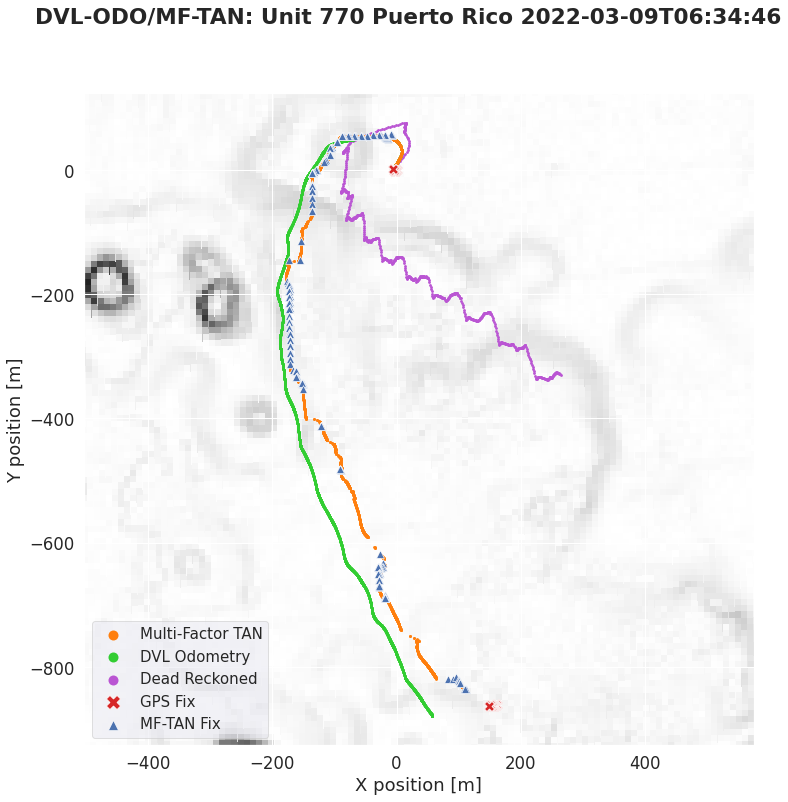

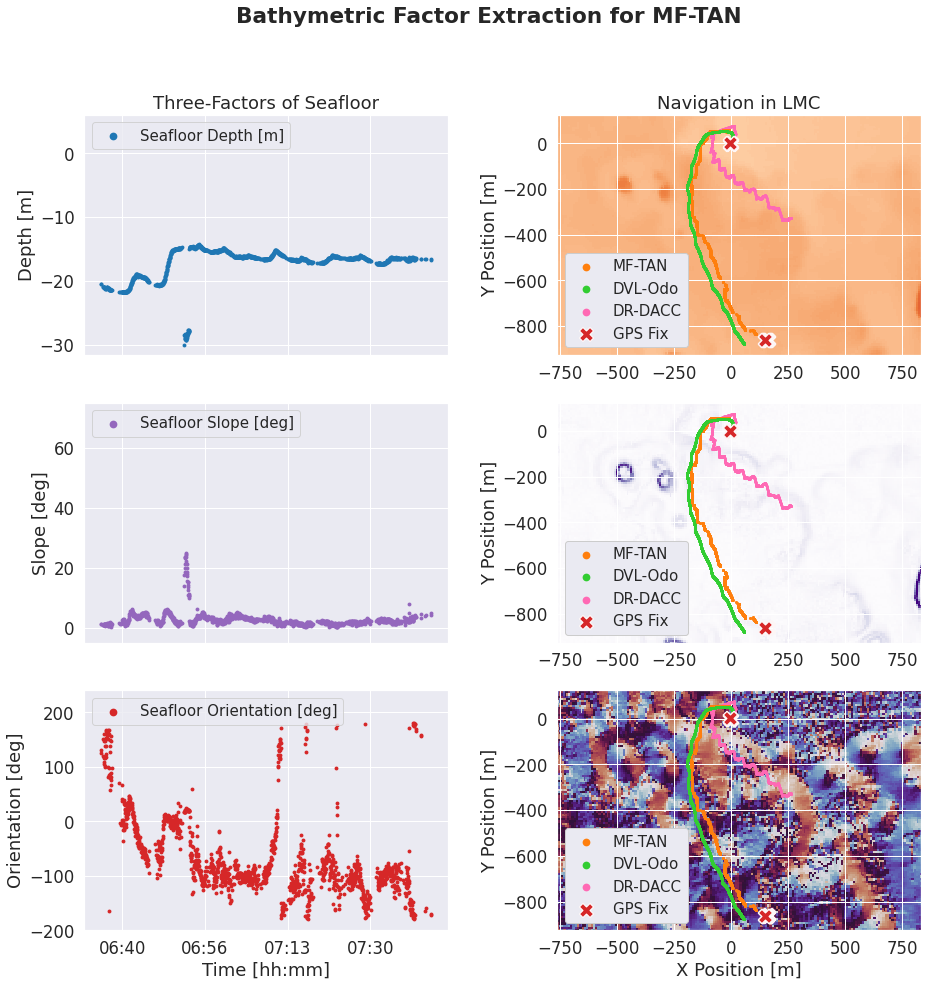

In [416]:
reload_modules()
#MF-TAN things. Need to test on DAVE Desktop

#bathy_factor_depth is currently just the inverse of AUG depth soooo something is wrong with how bathy factor is being calculated

#Need to distinguish between bathy_factor_depth and pc_factor_depth

#TODO breaks if there are no TAN factors to plot
# Plot profile and navigation
dvl_plotter_unit770_PR.plot_navigation(ts, df_dbd, bathy_df, 'unit_770', save_name=path_to_save_to + selected_dive + '_profile_nav.png')

#TODO look at how bathy_factor_x,y,z are being calculated
# Plot profile and Nav and Three Factors (edit and modify once MF-TAN is working)
dvl_plotter_unit770_PR.plot_profile_and_odometry_and_dr_and_three_factors(ts, df_dbd ,bathy_df, save_name=path_to_save_to + selected_dive + '_profile_odo_dr_w_3fac.png')




In [ ]:
# Exploitative Depth Band Selection 
#TODO would need to look into further

# plot_exploitative_depth_bands(dive_list, climb_list, TC_list,
#     glider_heading, voc_u_list, voc_v_list, voc_w_list, voc_z_list, 
#     save_name=None):

---
<a id='sandbox'></a>
## Sandbox

In [ ]:
# Sandbox
# plt.figure()
# plt.plot(ts.df.rel_pos_x, ts.df.rel_pos_y)
# #plt.plot(rel_pos_x_noBL, rel_pos_y_noBL)
# plt.title('Estimated Track')
# plt.axis('equal')
# #plt.axis([-100, 350, -100, 800])
# plt.xlabel('Eastings [m]')
# plt.ylabel('Northings [m]')
# #plt.plot(ts.df.rel_pos_x[num_bottom_lock_to_init], ts.df.rel_pos_y[num_bottom_lock_to_init], '+')
# #plt.legend(['with bottom-lock', 'no bottom-lock'], loc='lower left', fontsize='xx-small')

# plt.figure()
# plt.plot(ts.df.rel_pos_x, ts.df.rel_pos_y, '*')
# plt.title('Estimated Track in LMC')
# plt.xlabel('Eastings [m]')
# plt.ylabel('Northings [m]')
# #plt.plot(rel_pos_x_noBL, rel_pos_y_noBL, '*')
# #plt.plot(ts.df.rel_pos_x[num_bottom_lock_to_init], ts.df.rel_pos_y[num_bottom_lock_to_init], '+')
# #plt.legend(['with bottom-lock', 'no bottom-lock'], loc='lower left', fontsize='xx-small')

plt.figure()
plt.plot(u_list)
plt.ylabel('East Velocity [m/s]')
             

plt.figure()
plt.plot(v_list)
plt.ylabel('North Velocity [m/s]')


plt.figure()
plt.plot(v_list,-ts.df.ctd_depth[0:-1], 'o')
plt.ylabel('Depth [m]')
plt.xlabel('North Velocity [m/s]')

plt.figure()
plt.plot(u_list, -ts.df.ctd_depth[0:-1],  'o')
plt.ylabel('Depth [m]')
plt.xlabel('East Velocity [m/s]')

u_list = np.array(u_list)
v_list = np.array(v_list)
magnitude = np.sqrt((v_list**2) + (u_list**2))
plt.figure()
plt.plot(magnitude, -ts.df.ctd_depth[0:-1])
plt.ylabel('Depth [m]')
plt.xlabel('Velocity Magnitude [m/s]')
#TODO re-bin at 3m for useful plot to help recognize (or not) accuracy --> trade off resolution for accuracy


plt.figure()
plt.plot(ts.df.time, ts.df.abs_vel_btm_u)
plt.title('abs_vel_btm_u')
plt.figure()
plt.plot(ts.df.time,ts.df.abs_vel_btm_v)
plt.title('abs_vel_btm_v')

In [ ]:
#Figure out rotation by using abs_vel to plot odometry
# plt.figure()
# plt.plot(ts.df.abs_vel_btm_u)
# plt.figure()
# plt.plot(ts.df.abs_vel_btm_v)
# plt.figure()
# plt.plot(ts.df.abs_vel_btm_w)

# initialize list for new odometry
rel_pos_x = [0]
rel_pos_y = [0]
rel_pos_z = [0]
delta_x_list = [0]
delta_y_list = [0]

vel_list_x = []
vel_list_y = []
u_list     = []
v_list     = []

# iterate through the dive file to update odometry
for t in range(1,len(ts.df)):
    time    = ts.df.ros_timestamp[t]
    prev_x  = rel_pos_x[-1]
    prev_y  = rel_pos_y[-1]
    delta_t = ts.df.delta_t[t]
    depth   = ts.df.ctd_depth[t]
    

    # retrieve over ground velocity from DVL in bottom track 
    vog_u = ts.df.abs_vel_btm_u[t]
    vog_v = ts.df.abs_vel_btm_v[t]
   
    # initialize delta values to zero
    delta_x, delta_y = 0,0
    
    # CASE 1: use bottom track overground velocity if available
    if (not np.isnan(vog_u)):
        delta_x = vog_u*delta_t
        delta_y = vog_v*delta_t
        vel_list_x.append(vog_u)
        vel_list_y.append(vog_v)
    

    # set current position to DVL odometry result 
    cur_x = delta_x + prev_x
    cur_y = delta_y + prev_y
    
    # update the odometry list of positions
    rel_pos_x.append(cur_x)
    rel_pos_y.append(cur_y)
    rel_pos_z.append(depth)
    delta_x_list.append(delta_x)
    delta_y_list.append(delta_y)
    
    
# add new odomety to the data frame
ts.df['rel_pos_x'] = rel_pos_x
ts.df['rel_pos_y'] = rel_pos_y
ts.df['rel_pos_z'] = rel_pos_z
ts.df['delta_x']   = delta_x_list
ts.df['delta_y']   = delta_y_list

print("> Finished Calculating Odometry!") 

plt.figure()
plt.plot(df_dbd.m_gps_x_lmc, df_dbd.m_gps_y_lmc, 'ro', markersize=10)
# plt.plot(df_dbd.m_x_lmc, df_dbd.m_y_lmc, '.g' )
plt.plot(ts.df.rel_pos_x, ts.df.rel_pos_y, '.b')
#plt.legend(['GPS', 'DR', 'ABS_VEL_BTM'])
plt.axis('equal')